# Predicción de Ventas Semanales por Tienda

Este proyecto tiene como objetivo estimar las ventas semanales por tienda utilizando información económica, climática y eventos especiales.

## 1. Contexto del problema (Business Understanding)

Se dispone de información histórica de ventas de 45 tiendas Walmart, donde cada tienda agrupa múltiples categorías de productos (departamentos). Las ventas han sido registradas de forma semanal, lo que permite analizar su evolución en el tiempo y su comportamiento bajo distintos contextos.

El objetivo es predecir las ventas semanales a nivel de categoría para cada tienda, utilizando el historial disponible y considerando factores que afectan directamente la demanda. Este enfoque permite capturar tanto las diferencias entre tiendas como entre categorías, aumentando el nivel de detalle y complejidad del problema.

Un aspecto clave del contexto es la presencia de semanas especiales asociadas a días festivos, como Acción de Gracias y Navidad, en las que las ventas presentan incrementos significativos respecto a una semana regular. Estos eventos introducen patrones no lineales y picos de demanda que deben ser considerados explícitamente en el análisis y el modelado.

La predicción de ventas futuras representa una de las principales preocupaciones en empresas de retail, ya que impacta directamente en la gestión de inventarios, la planificación de stocks, la definición de precios y la proyección de ingresos. Contar con estimaciones confiables permite reducir costos operativos, evitar quiebres de stock y mejorar la toma de decisiones estratégicas.

En este contexto, el problema se plantea como un desafío de modelado predictivo a nivel semanal, donde se busca aprovechar la información histórica para anticipar el comportamiento de las ventas considerando tanto la estructura de las tiendas como la influencia de eventos especiales.

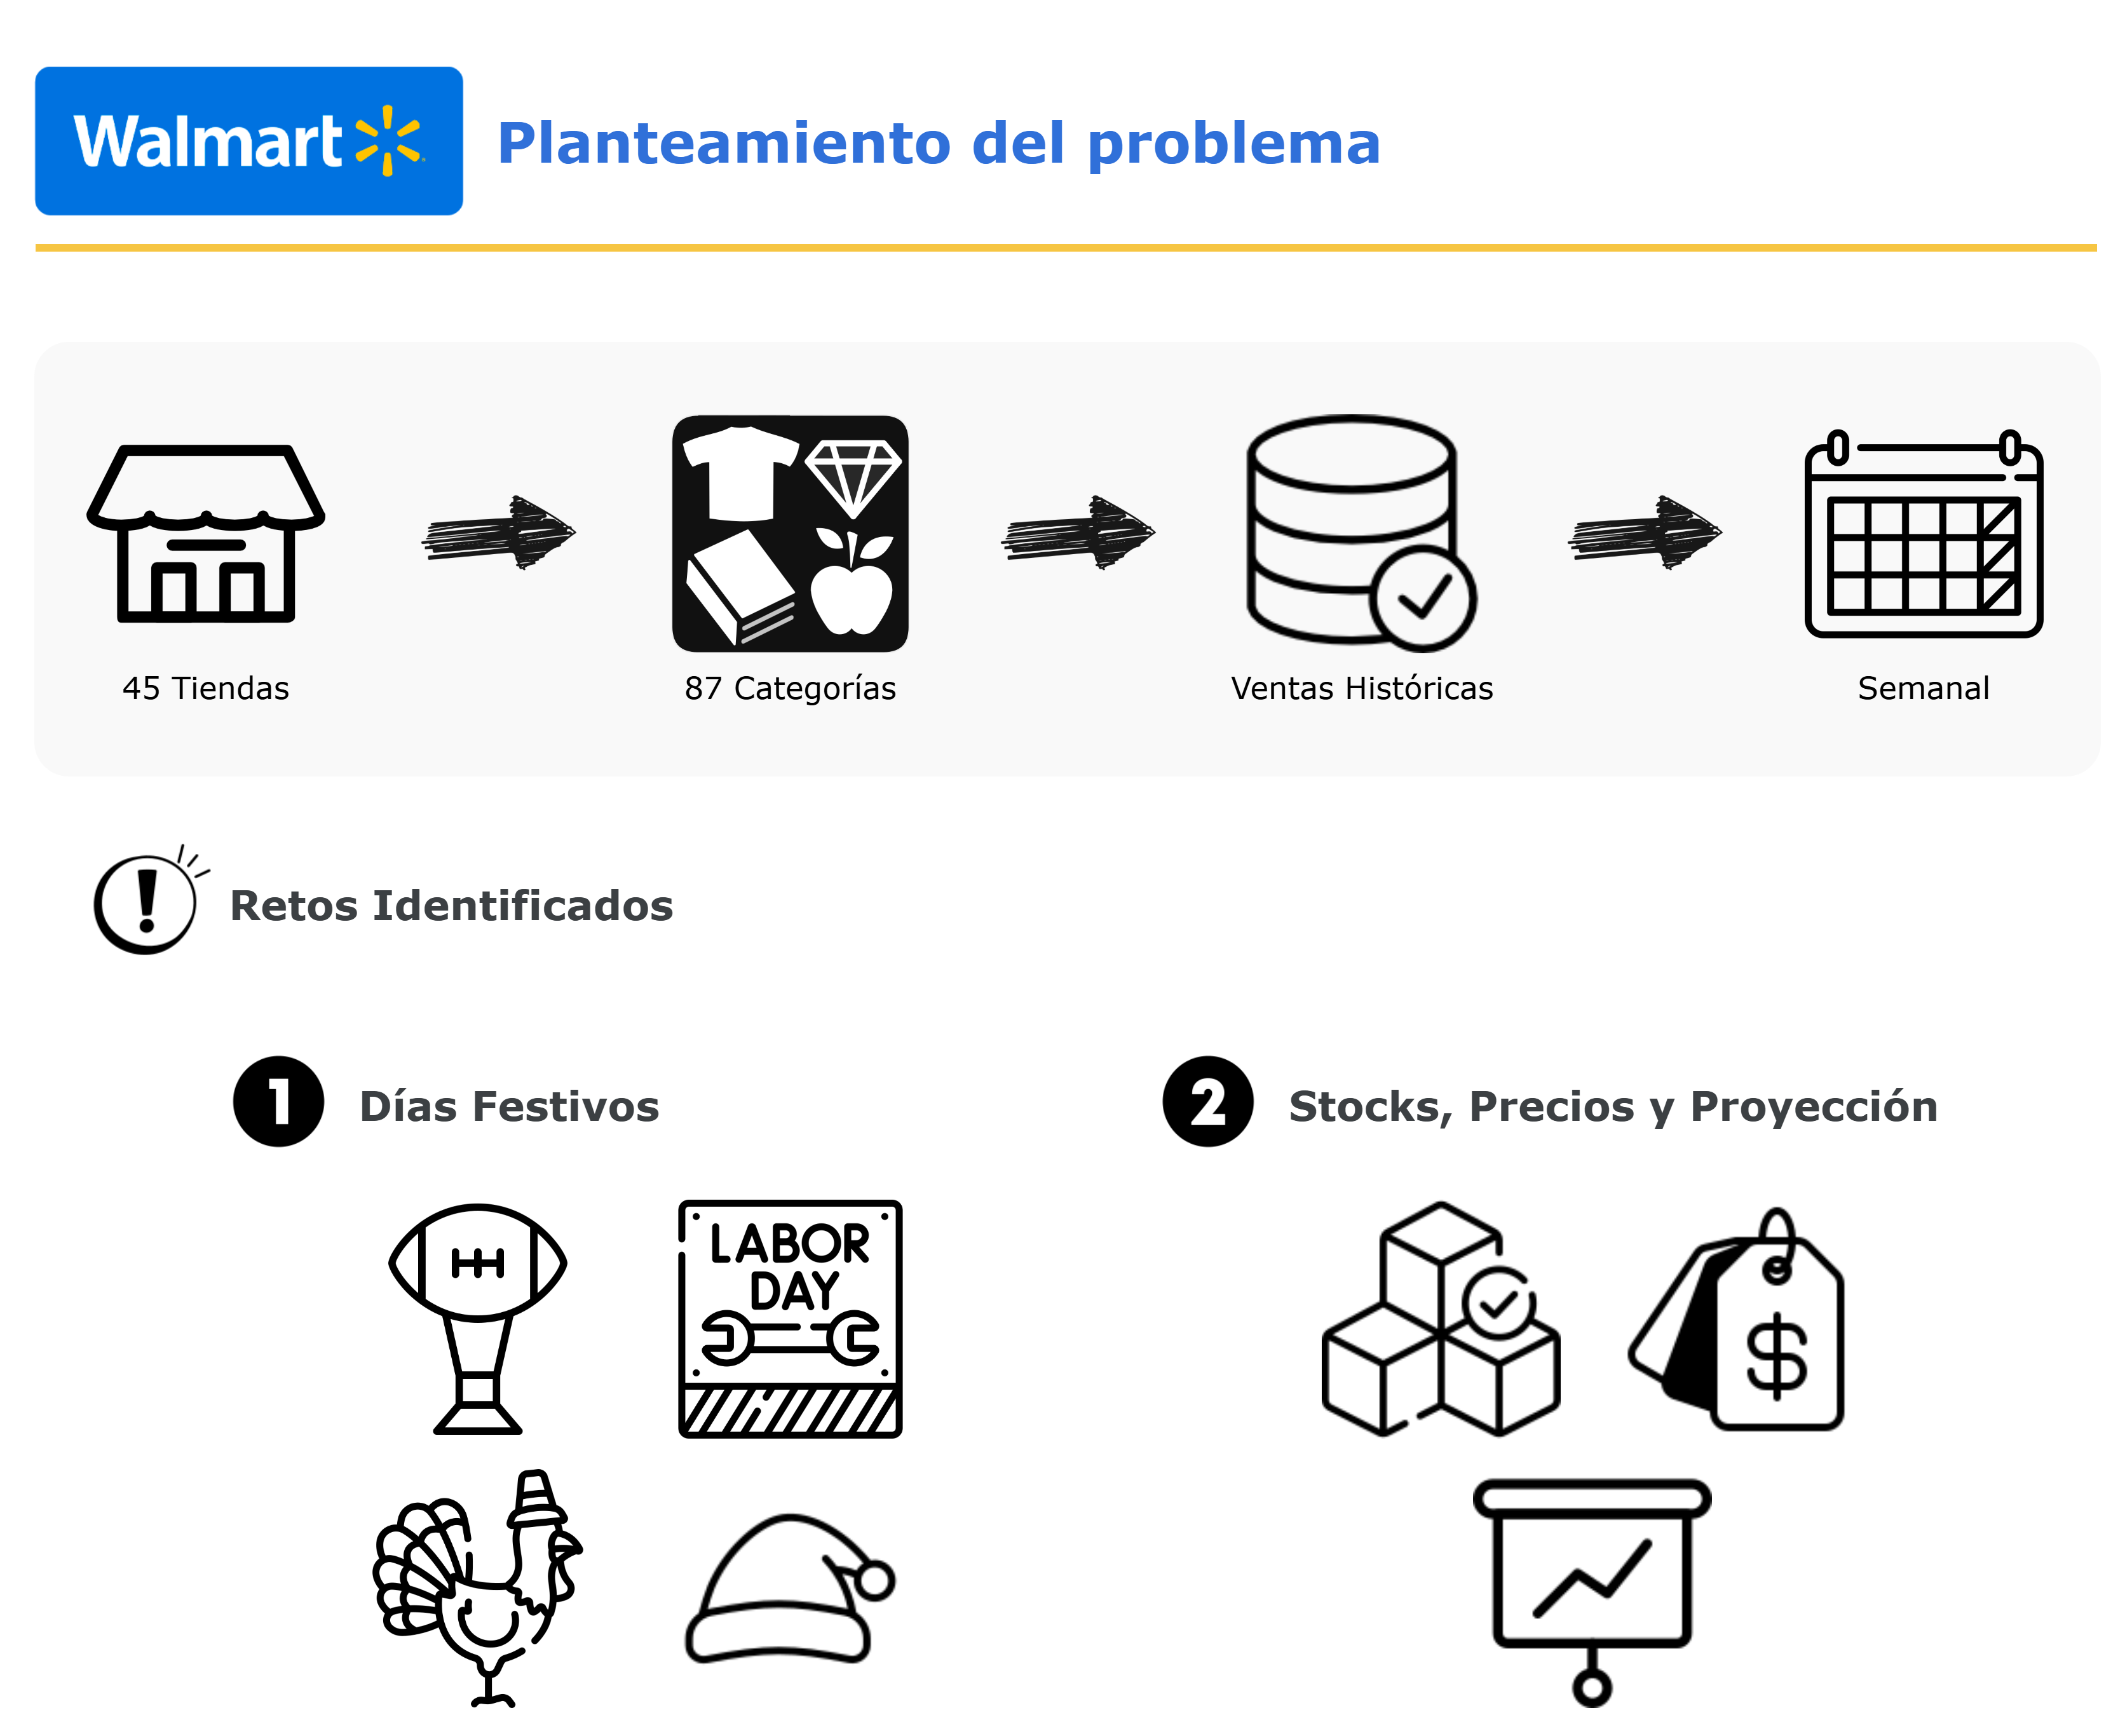

### 1.1 Objetivo

El objetivo principal de este proyecto es **estimar las ventas semanales por tienda** utilizando información histórica y variables externas relevantes, mediante el uso de técnicas de aprendizaje supervisado.

Objetivos Específicos

- Analizar la relación entre las ventas y variables económicas, climáticas y eventos especiales.
- Evaluar distintos enfoques de modelado predictivo para establecer referencias de desempeño.
- Comparar modelos simples y modelos de mayor complejidad con el fin de identificar aquel que ofrezca mejores estimaciones.
- Obtener un modelo que pueda servir como herramienta de apoyo para la planificación del área financiera y de marketing para que puedan hacer un plan de ventas con mayor facilidad.

## 2. Descripción general de los datos (Data Understanding)

Se cuenta con datos históricos de ventas, variables económicas y climáticas, así como información estructural de las tiendas.

- **train.csv**:

    Datos históricos con ventas → dataset principal de entrenamiento, la data va desde el 05-02-2010 hasta el 01-11-2012 y tiene los campos:

    - Store - el número de tienda
    - Dept - número de departamento
    - Date - representación de la semana
    - Weekly_Sales - ventas del departamento en la tienda correspondiente
    - IsHoliday - si la semana es una semana especial de festividad

- **test.csv**:

    Datos sin ventas → dataset para predicción. Este archivo es idéntico a train.csv, salvo que no tenemos la data de las ventas semanales. Servirá para predecir las ventas de cada triplete de tienda, departamento y fecha en este archivo.

- **features.csv**:

    Variables económicas y climáticas.
    Este archivo contiene datos adicionales relacionados con la tienda, el departamento y la actividad para las fechas indicadas. Contiene los siguientes campos:

    - Store - el número de tienda
    - Date - la semana
    - Temperature - temperatura media en la región
    - Fuel_Price - coste del combustible en la región
    - MarkDown1-5 - datos relacionados con descuentos promocionales.
    - CPI - el índice de precios al consumidor
    - Unemployment: la tasa de desempleo
    - IsHoliday - si la semana es una semana especial de festividad

- **stores.csv**:

    Información sobre las 45 tiendas, indicando el tipo y tamaño de la tienda.

- **sampleSubmission.csv**:

    Formato esperado de salida (referencial)
    Para cada fila del conjunto de prueba (tienda + departamento + triplete de fecha), deberías predecir las ventas semanales de ese departamento. La columna Id se forma concatenando el Almacén, el Departamento y la Fecha con guiones bajos (por ejemplo, Store_Dept_2012-11-02)

### 2.2 Variable objetivo

- **Nombre**: Weekly_Sales, ventas semanales por tienda
- **Tipo**: Numérica
- **Unidad de predicción**: Semanal

### 2.3 Features

- **Variables Económicas**: 
    - Índices económicos (CPI)
    - Tasa de desempleo (Unemployment)
    - Precio del combustible (Fuel_Price)
- **Variables Climáticas**:
    - Temperatura promedio semanal (Temperature)
- **Eventos especiales**: 
    - Indicador de semanas festivas (IsHoliday)
- **Características de tienda**: 
    - Tipo de tienda (Type)
    - Tamaño de la tienda (Size)   
- **Temporalidad**: 
    - Fecha
    - Semana
    - Año

### 2.4 Tamaño y estructura del dataset

In [198]:
import pandas as pd
from pathlib import Path

def resumen_dataset(ruta_csv):
    """
    Genera un resumen básico del tamaño y estructura de un archivo CSV.
    """
    df = pd.read_csv(ruta_csv)
    
    resumen = {
        "archivo": Path(ruta_csv).name,
        "filas": df.shape[0],
        "columnas": df.shape[1],
        "columnas_numericas": df.select_dtypes(include="number").shape[1],
        "columnas_categoricas": df.select_dtypes(exclude="number").shape[1],
        "valores_nulos_totales": df.isnull().sum().sum(),
        "memoria_MB": round(df.memory_usage(deep=True).sum() / 1024**2, 2)
    }
    
    return resumen


# Lista de archivos de entrada
RUTA = "./walmart-recruiting-store-sales-forecasting/data/2.extracted/"
archivos = [
    "train.csv",
    "test.csv",
    "features.csv",
    "stores.csv",
]

# Generar resumen para cada archivo
resumenes = [resumen_dataset(RUTA + archivo) for archivo in archivos]

# Consolidar resultados en un DataFrame
df_resumen = pd.DataFrame(resumenes)

df_resumen


,archivo,filas,columnas,columnas_numericas,columnas_categoricas,valores_nulos_totales,memoria_MB
0,train.csv,421570,5,3,2,0,17.29
1,test.csv,115064,4,2,2,0,3.84
2,features.csv,8190,12,10,2,24040,0.77
3,stores.csv,45,3,2,1,0,0.00


## 3. Exploración inicial de los datos

El objetivo de esta sección es comprender la estructura del dataset, analizar el comportamiento de la variable objetivo y detectar posibles desafíos antes de la etapa de modelado.

### 3.1 Stores CSV

In [199]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

df_stores = pd.read_csv(RUTA + 'stores.csv')
print(df_stores.head())

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


In [200]:
df_stores.info()
print(df_stores.describe())
print(df_stores["Type"].value_counts())

<class 'pandas.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Store   45 non-null     int64
 1   Type    45 non-null     str  
 2   Size    45 non-null     int64
dtypes: int64(2), str(1)
memory usage: 1.2 KB
           Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000
Type
A    22
B    17
C     6
Name: count, dtype: int64


<Axes: xlabel='Type', ylabel='Size'>

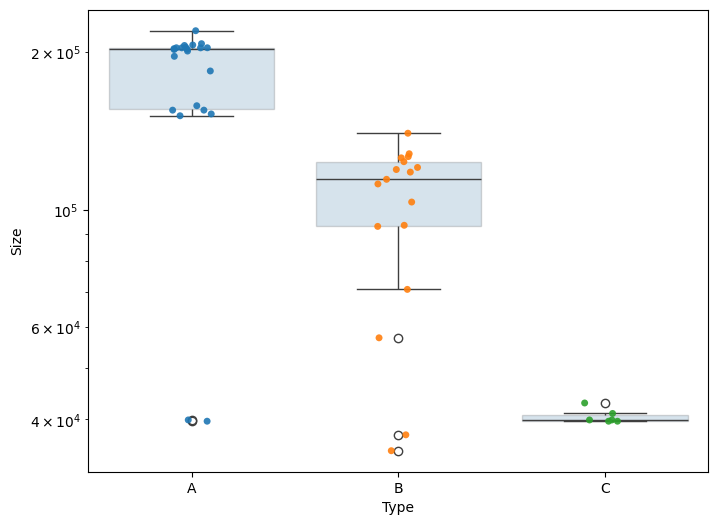

In [201]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(data=df_stores, x="Type", y="Size", ax=ax, boxprops=dict(alpha=0.2), log_scale=True)
sns.stripplot(data=df_stores, x="Type", y="Size", ax=ax, hue="Type", alpha=0.9, log_scale=True)

<Axes: xlabel='Type', ylabel='Store'>

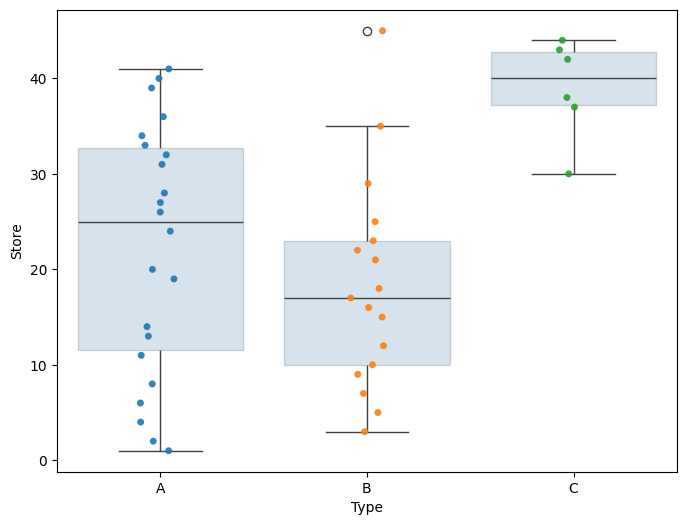

In [202]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(data=df_stores, x="Type", y="Store", ax=ax, boxprops=dict(alpha=0.2))
sns.stripplot(data=df_stores, x="Type", y="Store", ax=ax, hue="Type", alpha=0.9)

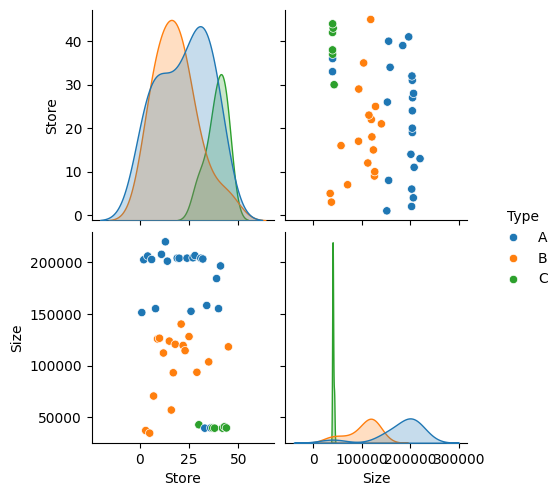

In [203]:
sns.pairplot(df_stores, hue="Type")

### 3.2 Train CSV

In [204]:
df_train = pd.read_csv(RUTA + 'train.csv')
print(df_train.head())

   Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False


In [205]:
df_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  str    
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), str(1)
memory usage: 17.3 MB


<Axes: >

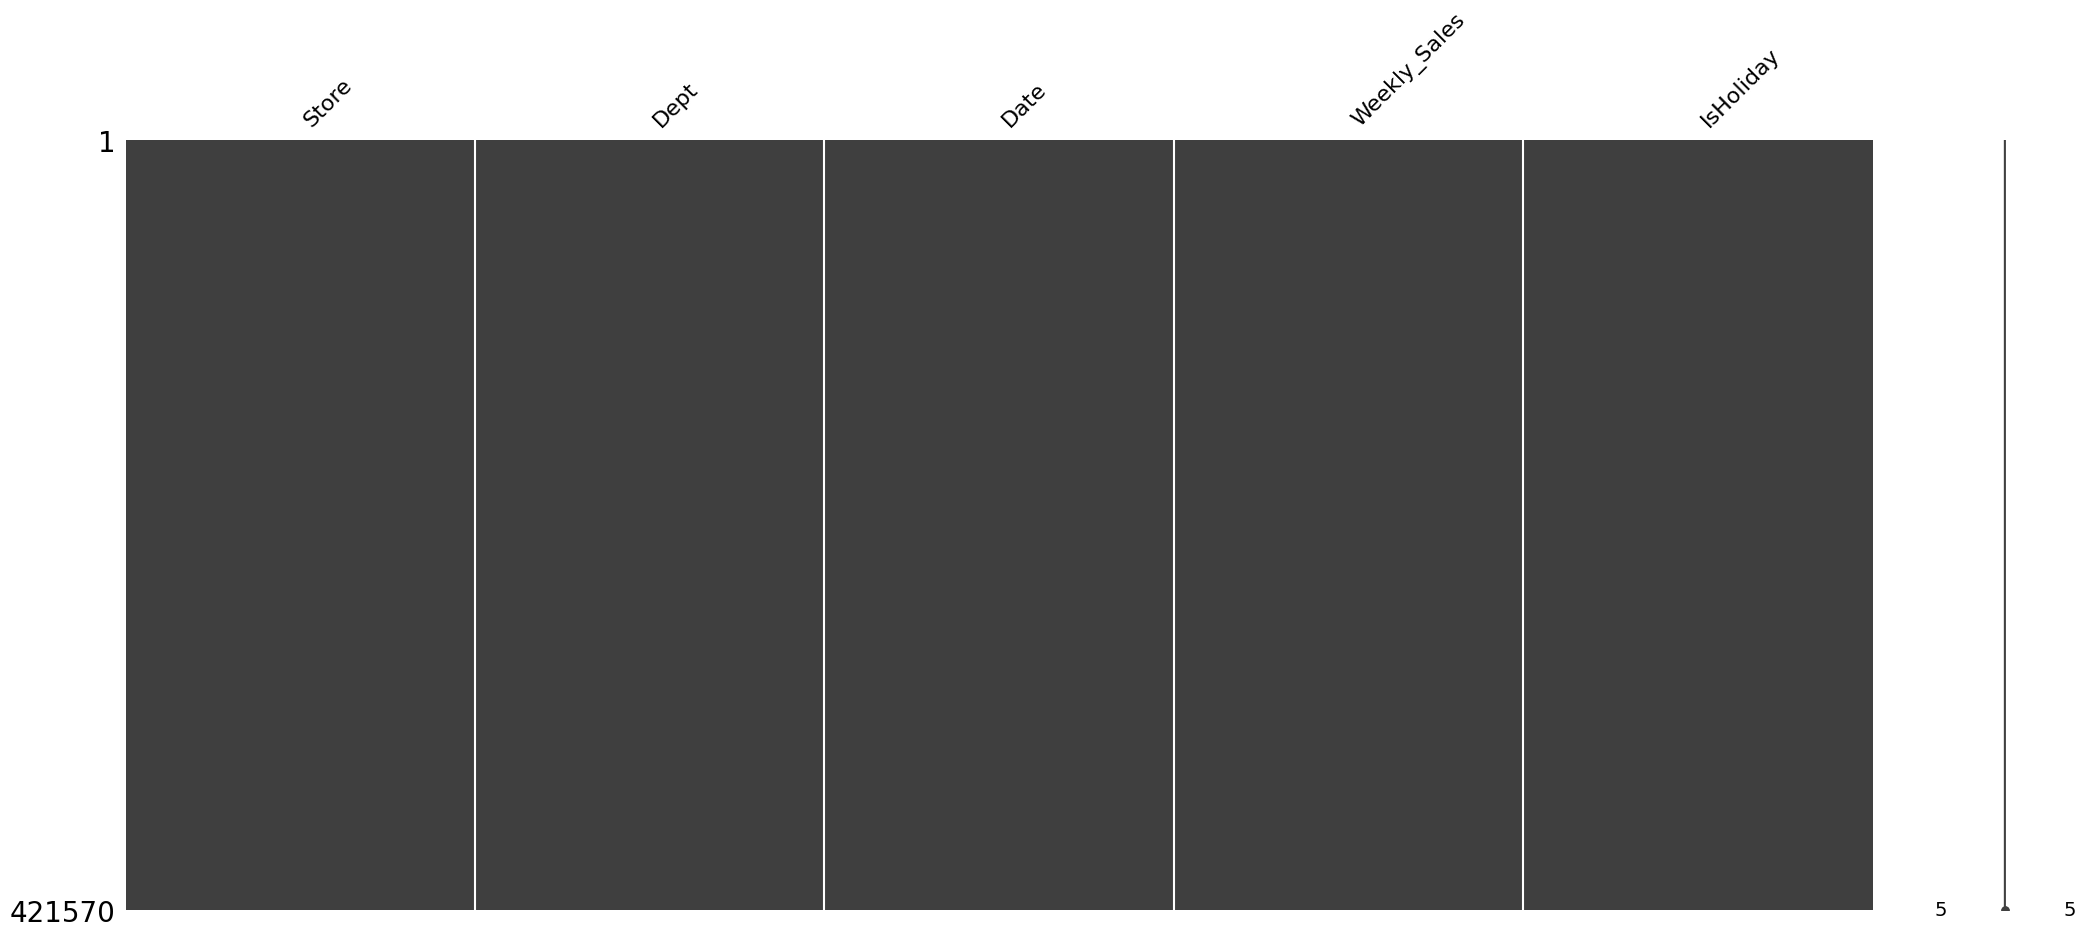

In [206]:
msno.matrix(df_train)

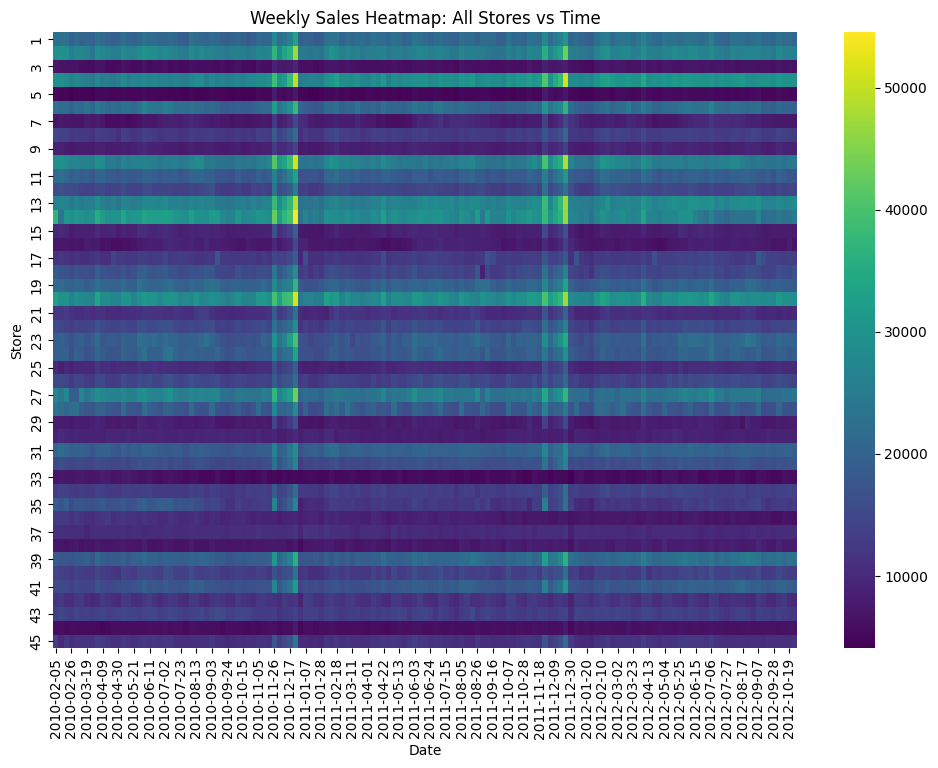

In [207]:
df_pivot = df_train.pivot_table(index="Store", columns="Date", values="Weekly_Sales")

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_pivot, cmap="viridis", ax=ax)

plt.title("Weekly Sales Heatmap: All Stores vs Time")
plt.show()

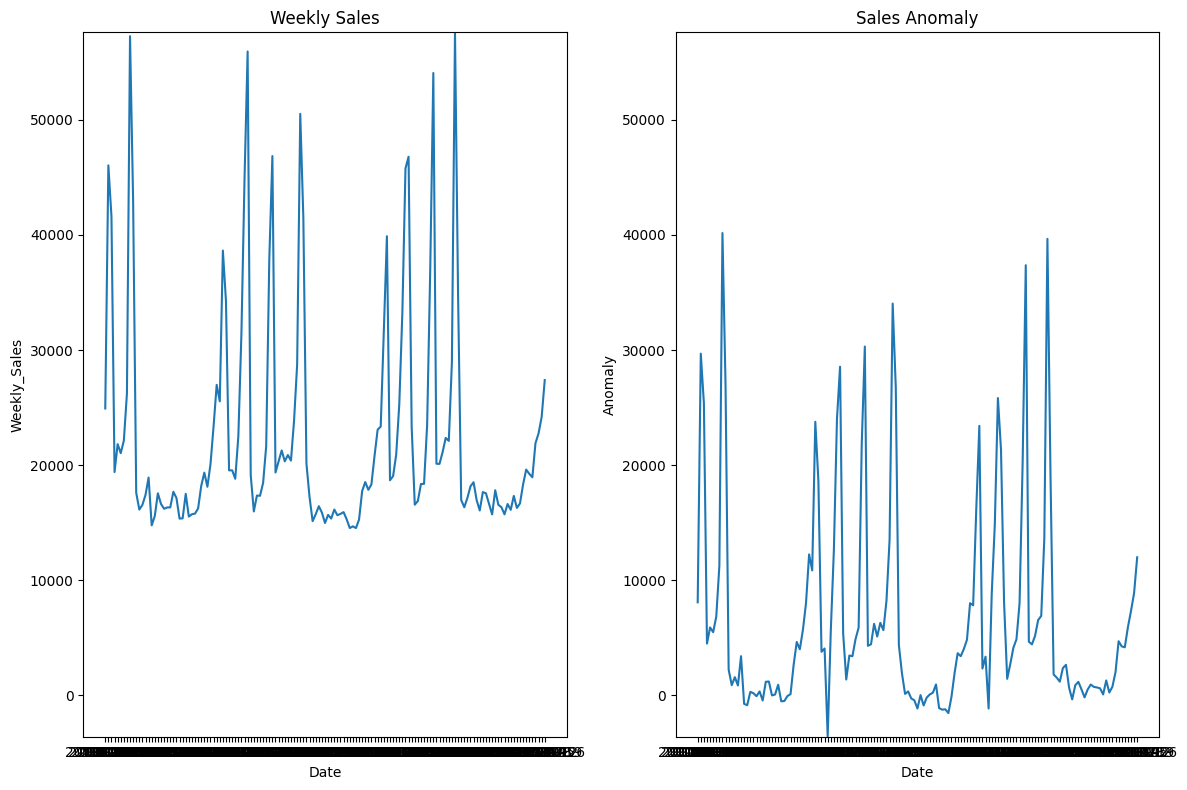

In [210]:
df_subset = df_train[(df_train["Store"] == 1 ) & (df_train["Dept"] == 1)]

df_climatology = df_train.groupby("Date")["Weekly_Sales"].mean().reset_index().rename(columns={"Weekly_Sales": "Climatology"})

df_plot = pd.merge(df_subset, df_climatology, on="Date")

df_plot["Anomaly"] = df_plot["Weekly_Sales"] - df_plot["Climatology"]

fig, ax = plt.subplots(figsize=(12, 8), ncols=2)
# plot both series and force the same y-range across subplots
sns.lineplot(data=df_plot, x="Date", y="Weekly_Sales", ax=ax[0])
plt.title("Sales Anomaly for Store 1, Dept 1")
sns.lineplot(data=df_plot, x="Date", y="Anomaly", ax=ax[1])

# compute common y-limits from both series
y_min = min(df_plot["Weekly_Sales"].min(), df_plot["Anomaly"].min())
y_max = max(df_plot["Weekly_Sales"].max(), df_plot["Anomaly"].max())
ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

ax[0].set_title("Weekly Sales")
ax[1].set_title("Sales Anomaly")
plt.tight_layout()

In [211]:
df_plot

,Store,Dept,Date,Weekly_Sales,IsHoliday,Climatology,Anomaly
0,1,1,2010-02-05,24924.50,False,16836.121997,8088.378003
1,1,1,2010-02-12,46039.49,True,16352.056032,29687.433968
2,1,1,2010-02-19,41595.55,False,16216.658979,25378.891021
3,1,1,2010-02-26,19403.54,False,14899.549688,4503.990312
4,1,1,2010-03-05,21827.90,False,15921.015727,5906.884273
...,...,...,...,...,...,...,...
138,1,1,2012-09-28,18947.81,False,14765.327279,4182.482721
139,1,1,2012-10-05,21904.47,False,15983.413747,5921.056253
140,1,1,2012-10-12,22764.01,False,15427.596739,7336.413261
141,1,1,2012-10-19,24185.27,False,15295.732397,8889.537603


### 3.3 Test CSV

In [212]:
df_test = pd.read_csv(RUTA + 'test.csv')
print(df_test.head())

   Store  Dept        Date  IsHoliday
0      1     1  2012-11-02      False
1      1     1  2012-11-09      False
2      1     1  2012-11-16      False
3      1     1  2012-11-23       True
4      1     1  2012-11-30      False


In [213]:
df_test.info()

<class 'pandas.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   Store      115064 non-null  int64
 1   Dept       115064 non-null  int64
 2   Date       115064 non-null  str  
 3   IsHoliday  115064 non-null  bool 
dtypes: bool(1), int64(2), str(1)
memory usage: 3.8 MB


### 3.4 Features CSV

In [214]:
df_features = pd.read_csv(RUTA + 'features.csv')
print(df_features.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  


In [215]:
df_features.info()

<class 'pandas.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   str    
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), str(1)
memory usage: 791.9 KB


<Axes: >

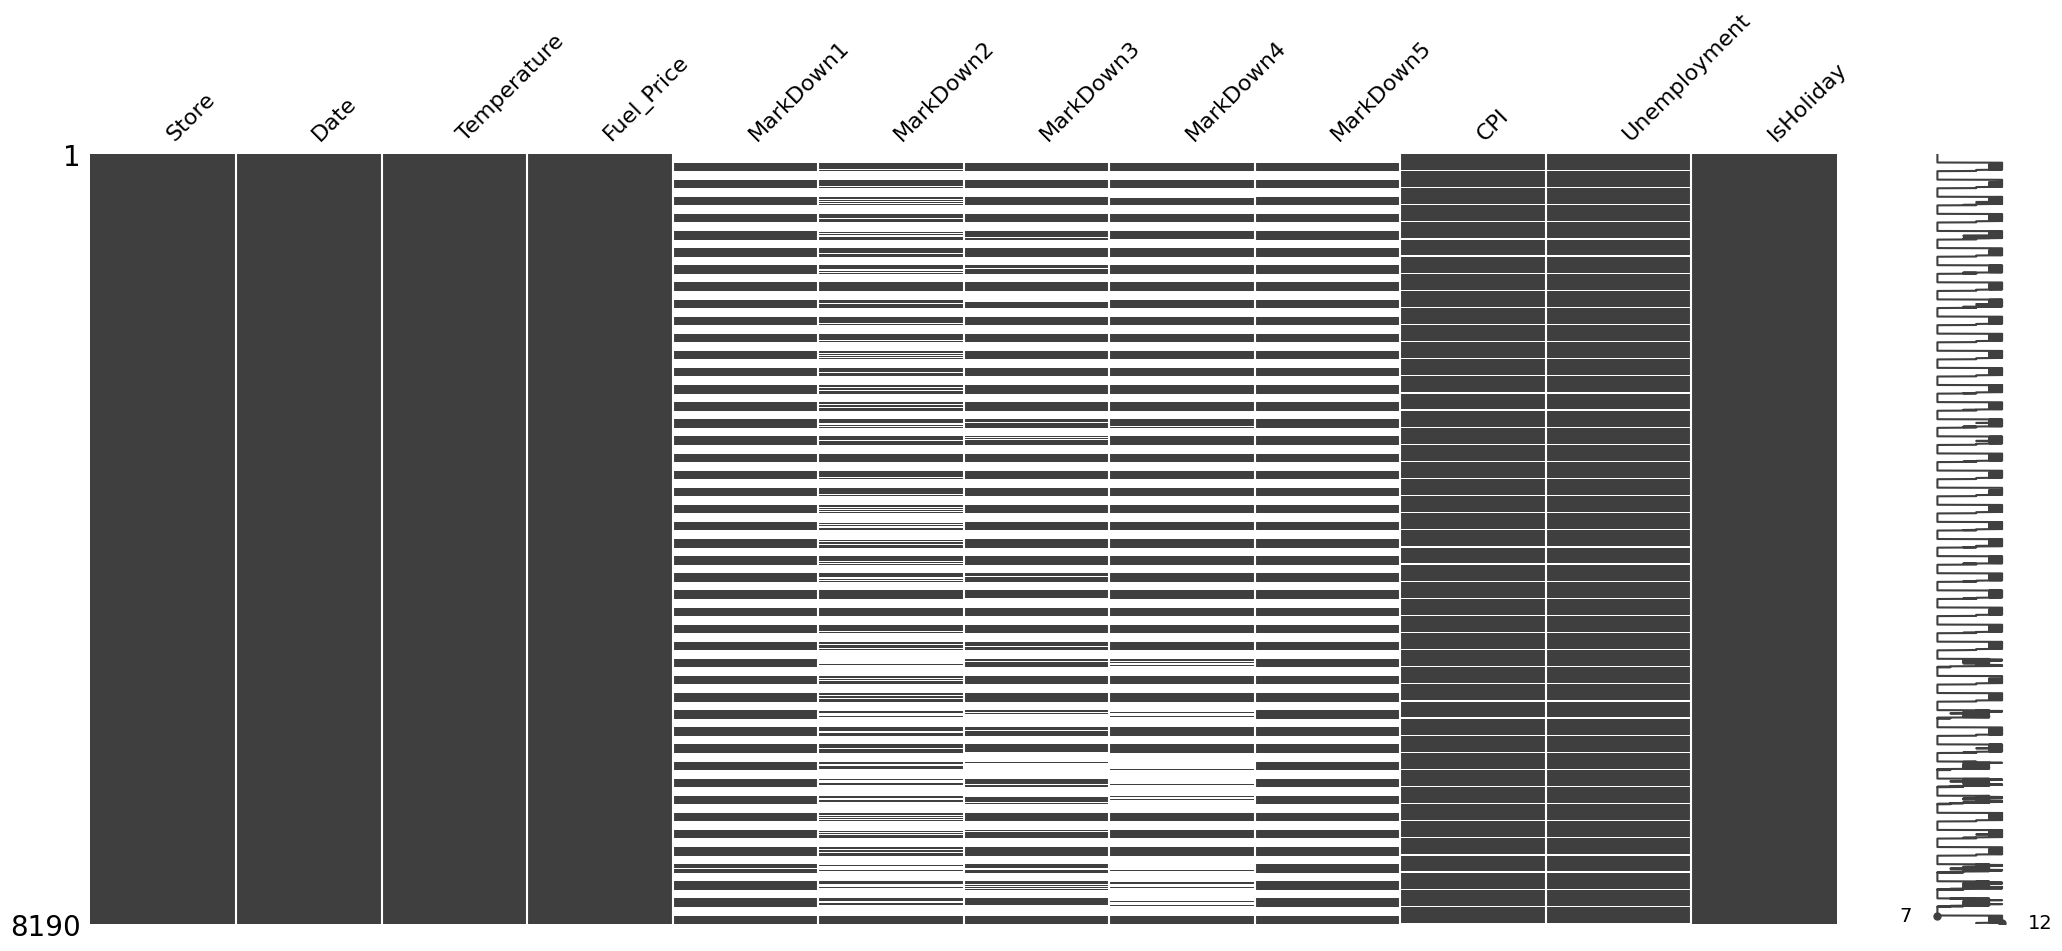

In [216]:
import missingno as msno

msno.matrix(df_features)

<Axes: >

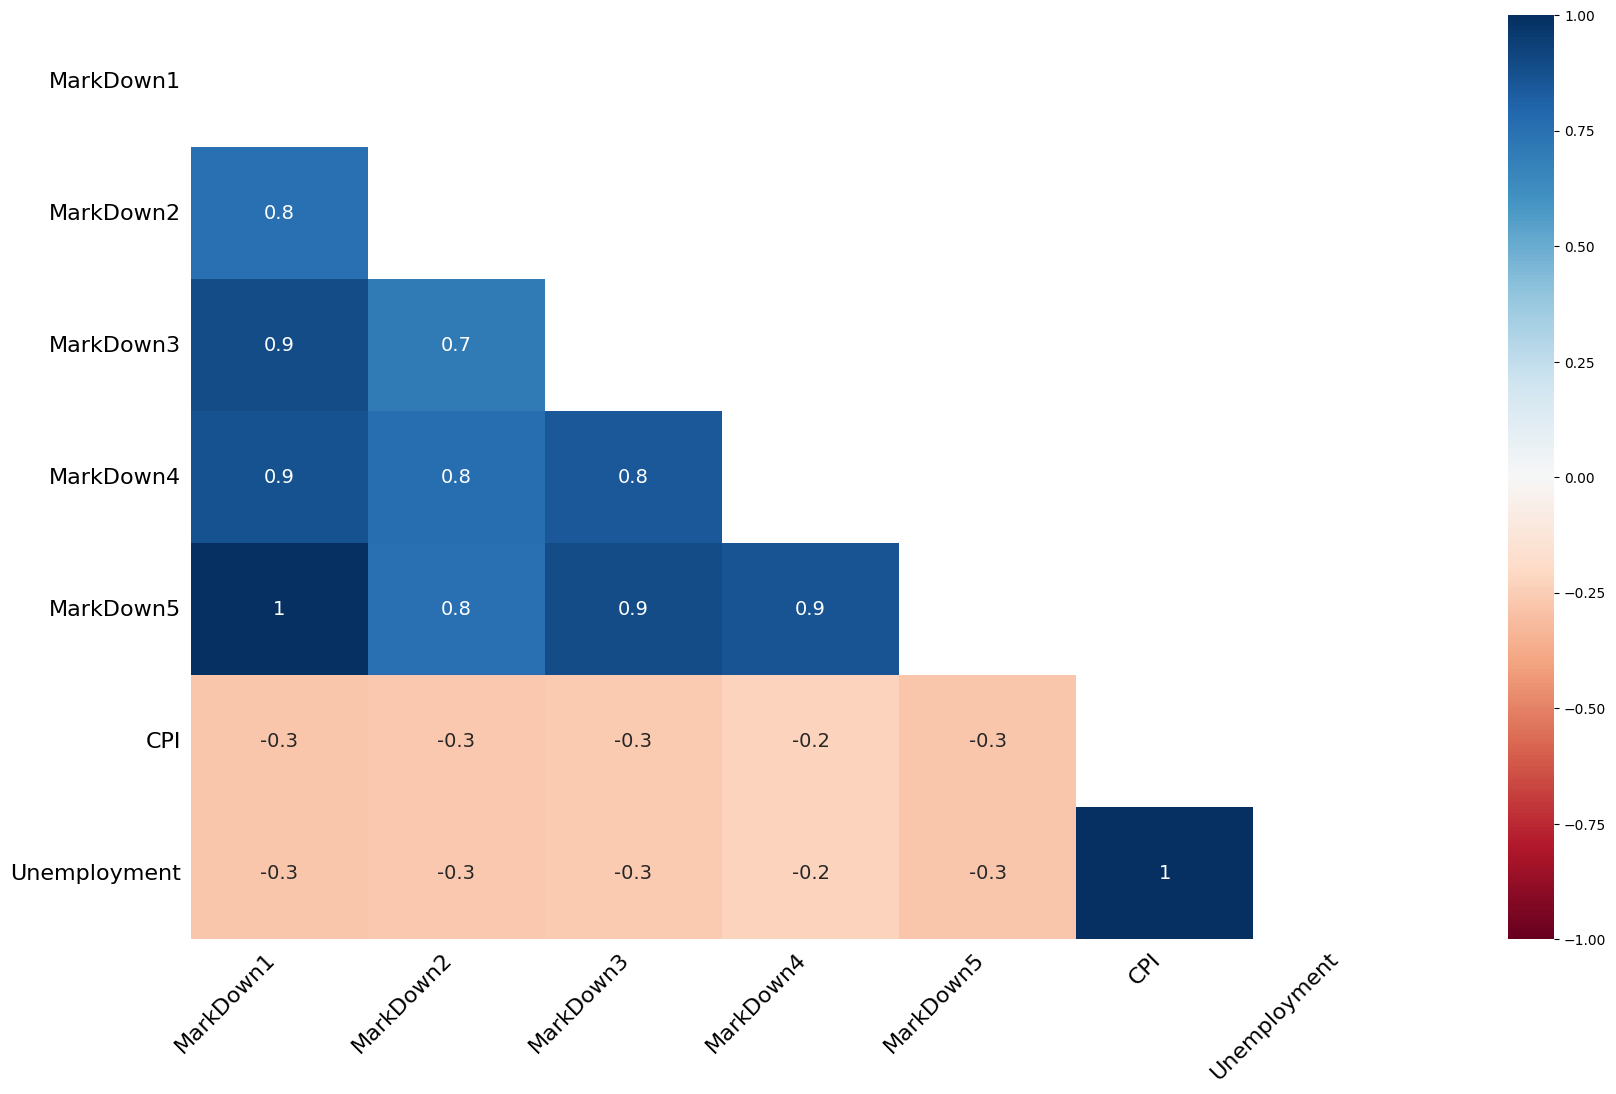

In [217]:
msno.heatmap(df_features)

## 4. Consideraciones y desafíos del problema

Se identifican desafíos como variabilidad entre tiendas, presencia de eventos especiales y dependencia temporal.

El problema de predicción de ventas semanales presenta desafíos estructurales que influyen directamente en la elección del modelo y en su desempeño.

En primer lugar, existe una alta variabilidad entre tiendas y categorías, lo que introduce heterogeneidad en los datos. No todas las tiendas responden igual a factores económicos o estacionales, lo que dificulta la construcción de un modelo único que generalice perfectamente en todos los casos.

En segundo lugar, la presencia de eventos especiales, como semanas festivas, genera picos de demanda que no siguen un patrón lineal simple. Estos eventos introducen discontinuidades que deben modelarse explícitamente o ser capturadas mediante componentes estacionales.

Finalmente, la dependencia temporal es un componente dominante del problema. Las ventas semanales muestran patrones recurrentes y tendencias suaves, lo que implica que cualquier modelo que ignore la estructura temporal explícita tendrá limitaciones significativas.

Estos desafíos explican por qué no todos los enfoques predictivos presentan el mismo desempeño.

## 5. Enfoque de modelado

Se adopta una estrategia incremental, comenzando con modelos simples y avanzando hacia modelos más complejos.

El enfoque seguido fue:

1. Aplicar modelos base para establecer referencias iniciales de desempeño. Entre ellos tenemos a *Elastic Net* y *Random Forest*.

3. Aplicar un modelo de ensemble (AdaBoost) para modelar interacciones más complejas.

4. Aplicar un model basado en processo gaussianos con un estructura autoregresiva (AR).

5. Aplicar un modelo de series de tiempo ETS (Error, Trend, Seasonality).

6. Implementar un modelo de *Local Linear Regression (LLR)*.

La validación se realizó mediante un ***forward chaining cross validation*** con 4 folds y 13 semanas de validación por bloque, evitando fuga de información y simulando condiciones reales de forecasting.

Las métricas utilizadas fueron WMAE (principal), MAE y RMSE, permitiendo evaluar tanto precisión promedio como sensibilidad ante valores extremos.

### Setup para los modelos

In [124]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

PROJECT_ROOT = Path("/home/ppalacios/Documents/Regression_Challenge_3-Walmart")
DATA_ROOT = PROJECT_ROOT / "walmart-recruiting-store-sales-forecasting" / "data"
RAW_DIR = DATA_ROOT / "2.extracted"
PROCESSED_DIR = DATA_ROOT / "3.processed"


def ensure_prepared_features(root: Path = PROJECT_ROOT, force: bool = False) -> tuple[Path, Path]:
    processed_dir = root / "walmart-recruiting-store-sales-forecasting" / "data" / "3.processed"
    raw_dir = root / "walmart-recruiting-store-sales-forecasting" / "data" / "2.extracted"
    processed_dir.mkdir(parents=True, exist_ok=True)

    train_feat_path = processed_dir / "train_feat.parquet"
    test_feat_path = processed_dir / "test_feat.parquet"
    if not force and train_feat_path.exists() and test_feat_path.exists():
        return train_feat_path, test_feat_path

    train_csv = raw_dir / "train.csv"
    test_csv = raw_dir / "test.csv"
    features_csv = raw_dir / "features.csv"
    stores_csv = raw_dir / "stores.csv"
    required = [train_csv, test_csv, features_csv, stores_csv]
    missing = [str(p) for p in required if not p.exists()]
    if missing:
        raise FileNotFoundError(f"Missing required raw files: {missing}")

    train = pd.read_csv(train_csv)
    test = pd.read_csv(test_csv)
    features = pd.read_csv(features_csv)
    stores = pd.read_csv(stores_csv)

    for frame in (train, test, features):
        frame["Date"] = pd.to_datetime(frame["Date"], errors="coerce")

    for col in ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]:
        if col in features.columns:
            features[col] = features[col].fillna(0)

    if {"CPI", "Unemployment"}.issubset(features.columns):
        imp = IterativeImputer(max_iter=10, random_state=0)
        imputed = imp.fit_transform(features[["CPI", "Unemployment"]])
        features = features.drop(columns=["CPI", "Unemployment"])
        features[["CPI", "Unemployment"]] = imputed

    selected_cols = [
        "Store",
        "Date",
        "Temperature",
        "Fuel_Price",
        "MarkDown1",
        "MarkDown2",
        "MarkDown3",
        "MarkDown4",
        "MarkDown5",
        "CPI",
        "Unemployment",
    ]
    features = features[selected_cols]

    train_feat = train.merge(features, on=["Store", "Date"], how="left")
    train_feat = train_feat.merge(stores, on=["Store"], how="left")
    test_feat = test.merge(features, on=["Store", "Date"], how="left")
    test_feat = test_feat.merge(stores, on=["Store"], how="left")

    # After merging, enforce Markdown1-5 = 0.0 (and numeric) in the final processed frames.
    for col in ["MarkDown1", "MarkDown2", "MarkDown3", "MarkDown4", "MarkDown5"]:
        if col in train_feat.columns:
            train_feat[col] = pd.to_numeric(train_feat[col], errors="coerce").fillna(0.0)
        if col in test_feat.columns:
            test_feat[col] = pd.to_numeric(test_feat[col], errors="coerce").fillna(0.0)

    train_feat.to_parquet(train_feat_path, index=False, engine="pyarrow")
    test_feat.to_parquet(test_feat_path, index=False, engine="pyarrow")
    return train_feat_path, test_feat_path


def mean_row_from_metrics(metrics_df: pd.DataFrame) -> dict:
    if metrics_df.empty:
        raise ValueError("metrics_df is empty")
    mask = metrics_df["fold"].astype(str) == "mean"
    if mask.any():
        return metrics_df.loc[mask].iloc[0].to_dict()
    return metrics_df.iloc[-1].to_dict()


# Use force=True to regenerate processed parquets if you changed preprocessing logic.
# Use force=True to regenerate processed parquets if you changed preprocessing logic
# (e.g., to eliminate stale MarkDown NaNs in existing train_feat/test_feat files).
train_feat_path, test_feat_path = ensure_prepared_features(PROJECT_ROOT, force=True)
print(f"Using train features: {train_feat_path}")
print(f"Using test features:  {test_feat_path}")

Using train features: /home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet
Using test features:  /home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet


### Funciones para modelo *LLR*

In [218]:
import json
from collections import deque
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

TARGET_COL = "sales_anom"
LAG_ORDERS = (1, 2)
LAG_FEATURE_COLS = [f"sales_anom_lag{lag}" for lag in LAG_ORDERS]
FULL_EXOG_FEATURE_COLS = [
    "temp_anom",
    "fuel_anom",
    "MarkDown1",
    "MarkDown2",
    "MarkDown3",
    "MarkDown4",
    "MarkDown5",
    "CPI",
    "Unemployment",
]
LITE_EXOG_FEATURE_COLS = [
    "temp_anom",
    "fuel_anom",
]
CORE_FEATURE_COLS = [
    "sales_anom_lag1",
    "sales_anom_lag2",
    "is_holiday_int",
]
INTERACTION_FEATURE_COLS = [
    "holiday_x_lag1",
]
WEEK_PERIOD = 53

@dataclass(slots=True)
class LocalLinearConfig:
    kernel: str
    bandwidth: int
    min_samples: int
    ridge: float
    coef_clip: float
    anom_clip_scale: float
    use_interactions: bool
    feature_mode: str

@dataclass(slots=True)
class FittedLocalLinear:
    local_params: dict[tuple[str, int], np.ndarray]
    available_weeks: dict[str, np.ndarray]
    series_fallback: dict[str, np.ndarray]
    global_fallback: np.ndarray
    series_bounds: dict[str, tuple[float, float]]
    global_bounds: tuple[float, float]
    feature_cols: list[str]
    feature_means: np.ndarray
    feature_stds: np.ndarray

def get_feature_cols(config: LocalLinearConfig) -> list[str]:
    cols = list(get_exog_feature_cols(config)) + list(CORE_FEATURE_COLS)
    if config.use_interactions:
        cols.extend(INTERACTION_FEATURE_COLS)
    return cols

def get_exog_feature_cols(config: LocalLinearConfig) -> list[str]:
    if config.feature_mode == "lite":
        return list(LITE_EXOG_FEATURE_COLS)
    return list(FULL_EXOG_FEATURE_COLS)

def weighted_ridge_fit(X: np.ndarray, y: np.ndarray, weights: np.ndarray, ridge: float) -> np.ndarray:
    if X.size == 0:
        return np.zeros(X.shape[1] + 1, dtype=float)

    design = np.column_stack([np.ones(X.shape[0], dtype=float), X])
    sqrt_w = np.sqrt(np.clip(weights, 0.0, None))
    Xw = design * sqrt_w[:, None]
    yw = y * sqrt_w

    reg = np.eye(Xw.shape[1], dtype=float) * ridge
    reg[0, 0] = 0.0

    xtx = Xw.T @ Xw + reg
    xty = Xw.T @ yw
    beta = np.linalg.pinv(xtx) @ xty
    return beta.astype(float, copy=False)

def regularize_beta(beta: np.ndarray, coef_clip: float) -> np.ndarray:
    out = beta.copy()
    out[1:] = np.clip(out[1:], -coef_clip, coef_clip)
    return out

def cyclic_week_distance(weeks: np.ndarray, target_week: int) -> np.ndarray:
    delta = np.abs(weeks - target_week)
    return np.minimum(delta, WEEK_PERIOD - delta)

def kernel_weights(distance: np.ndarray, bandwidth: int, kernel: str) -> np.ndarray:
    if kernel == "tricube":
        scaled = np.clip(distance / float(bandwidth), 0.0, 1.0)
        weights = (1.0 - scaled**3) ** 3
        weights[distance > bandwidth] = 0.0
        return weights
    if kernel == "exponential":
        return np.exp(-0.5 * (distance / float(bandwidth)) ** 2)
    raise ValueError(f"Unsupported kernel: {kernel}")

def robust_bounds(values: np.ndarray, clip_scale: float) -> tuple[float, float]:
    if values.size == 0:
        return (-1.0, 1.0)
    q01, q99 = np.quantile(values, [0.01, 0.99])
    std = float(np.std(values))
    span = max(float(q99 - q01), std, 1.0)
    lower = float(q01 - clip_scale * span)
    upper = float(q99 + clip_scale * span)
    if lower >= upper:
        center = float(np.median(values))
        lower, upper = center - 1.0, center + 1.0
    return (lower, upper)

def fit_standard_scaler(X: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    bad = (~np.isfinite(stds)) | (stds < 1e-8)
    stds[bad] = 1.0
    means[~np.isfinite(means)] = 0.0
    return means.astype(float, copy=False), stds.astype(float, copy=False)

def apply_standard_scaler(X: np.ndarray, means: np.ndarray, stds: np.ndarray) -> np.ndarray:
    return (X - means) / stds

def load_data(train_path: Path, test_path: Path, max_series: int | None) -> tuple[pd.DataFrame, pd.DataFrame]:
    train = pd.read_parquet(train_path)
    test = pd.read_parquet(test_path)

    for frame in (train, test):
        frame["Date"] = pd.to_datetime(frame["Date"], errors="coerce")
        frame["Store"] = frame["Store"].astype(int)
        frame["Dept"] = frame["Dept"].astype(int)
        frame["series_id"] = frame["Store"].astype(str) + "_" + frame["Dept"].astype(str)
        frame["week_of_year"] = frame["Date"].dt.isocalendar().week.astype(int)
        frame["is_holiday_int"] = frame["IsHoliday"].astype(int)

    if max_series is not None:
        keep_ids = (
            train["series_id"]
            .drop_duplicates()
            .sort_values()
            .head(max_series)
            .tolist()
        )
        train = train[train["series_id"].isin(keep_ids)].copy()
        test = test[test["series_id"].isin(keep_ids)].copy()

    train = train.sort_values(["Date", "Store", "Dept"]).reset_index(drop=True)
    test = test.sort_values(["Date", "Store", "Dept"]).reset_index(drop=True)
    return train, test

def build_forward_folds(
    train_df: pd.DataFrame, n_folds: int, val_weeks: int
) -> list[tuple[int, np.ndarray, np.ndarray]]:
    unique_dates = np.array(sorted(train_df["Date"].dropna().unique()))
    initial_train = len(unique_dates) - (n_folds * val_weeks)
    if initial_train <= 0:
        raise ValueError(
            f"Not enough unique weeks ({len(unique_dates)}) for n_folds={n_folds}, val_weeks={val_weeks}."
        )

    folds: list[tuple[int, np.ndarray, np.ndarray]] = []
    for fold in range(n_folds):
        train_end = initial_train + fold * val_weeks
        val_end = train_end + val_weeks
        train_dates = unique_dates[:train_end]
        val_dates = unique_dates[train_end:val_end]
        folds.append((fold + 1, train_dates, val_dates))
    return folds

def compute_climatology(train_df: pd.DataFrame) -> dict[str, pd.DataFrame | dict[str, float]]:
    series = (
        train_df.groupby(["series_id", "week_of_year"], as_index=False)[
            ["Weekly_Sales", "Temperature", "Fuel_Price"]
        ]
        .median()
        .rename(
            columns={
                "Weekly_Sales": "clim_sales_series",
                "Temperature": "clim_temp_series",
                "Fuel_Price": "clim_fuel_series",
            }
        )
    )
    store = (
        train_df.groupby(["Store", "week_of_year"], as_index=False)[
            ["Weekly_Sales", "Temperature", "Fuel_Price"]
        ]
        .median()
        .rename(
            columns={
                "Weekly_Sales": "clim_sales_store",
                "Temperature": "clim_temp_store",
                "Fuel_Price": "clim_fuel_store",
            }
        )
    )
    global_week = (
        train_df.groupby("week_of_year", as_index=False)[["Weekly_Sales", "Temperature", "Fuel_Price"]]
        .median()
        .rename(
            columns={
                "Weekly_Sales": "clim_sales_global",
                "Temperature": "clim_temp_global",
                "Fuel_Price": "clim_fuel_global",
            }
        )
    )
    overall = {
        "sales": float(train_df["Weekly_Sales"].median()),
        "temp": float(train_df["Temperature"].median()),
        "fuel": float(train_df["Fuel_Price"].median()),
    }
    return {"series": series, "store": store, "global_week": global_week, "overall": overall}

def attach_climatology(
    df: pd.DataFrame, climatology: dict[str, pd.DataFrame | dict[str, float]]
) -> pd.DataFrame:
    out = df.merge(
        climatology["series"], on=["series_id", "week_of_year"], how="left"  # type: ignore[arg-type]
    )
    out = out.merge(climatology["store"], on=["Store", "week_of_year"], how="left")  # type: ignore[arg-type]
    out = out.merge(climatology["global_week"], on=["week_of_year"], how="left")  # type: ignore[arg-type]

    overall = climatology["overall"]  # type: ignore[assignment]
    out["clim_sales"] = (
        out["clim_sales_series"].fillna(out["clim_sales_store"]).fillna(out["clim_sales_global"]).fillna(overall["sales"])
    )
    out["clim_temp"] = (
        out["clim_temp_series"].fillna(out["clim_temp_store"]).fillna(out["clim_temp_global"]).fillna(overall["temp"])
    )
    out["clim_fuel"] = (
        out["clim_fuel_series"].fillna(out["clim_fuel_store"]).fillna(out["clim_fuel_global"]).fillna(overall["fuel"])
    )

    out["temp_anom"] = out["Temperature"] - out["clim_temp"]
    out["fuel_anom"] = out["Fuel_Price"] - out["clim_fuel"]
    if "Weekly_Sales" in out.columns:
        out["sales_anom"] = out["Weekly_Sales"] - out["clim_sales"]

    drop_cols = [
        "clim_sales_series",
        "clim_temp_series",
        "clim_fuel_series",
        "clim_sales_store",
        "clim_temp_store",
        "clim_fuel_store",
        "clim_sales_global",
        "clim_temp_global",
        "clim_fuel_global",
    ]
    return out.drop(columns=drop_cols, errors="ignore")

def add_anomaly_lags(df: pd.DataFrame) -> pd.DataFrame:
    out = df.sort_values(["series_id", "Date"]).copy()
    grp = out.groupby("series_id")["sales_anom"]
    for lag in LAG_ORDERS:
        out[f"sales_anom_lag{lag}"] = grp.shift(lag)
    out["holiday_x_lag1"] = out["is_holiday_int"] * out["sales_anom_lag1"]
    return out

def fit_local_models(train_df: pd.DataFrame, config: LocalLinearConfig) -> FittedLocalLinear:
    feature_cols = get_feature_cols(config)
    valid = train_df.copy()
    # Keep early rows by treating unavailable long-lag anomalies as neutral (0).
    for c in LAG_FEATURE_COLS + INTERACTION_FEATURE_COLS:
        if c in valid.columns:
            valid[c] = valid[c].fillna(0.0)
    for c in get_exog_feature_cols(config):
        if c in valid.columns and valid[c].isna().any():
            median = float(valid[c].median())
            if not np.isfinite(median):
                median = 0.0
            valid[c] = valid[c].fillna(median)
    valid = valid.dropna(subset=feature_cols + [TARGET_COL]).copy()
    if valid.empty:
        zero_beta = np.zeros(len(feature_cols) + 1, dtype=float)
        return FittedLocalLinear(
            {},
            {},
            {},
            zero_beta,
            {},
            (-1.0, 1.0),
            feature_cols,
            np.zeros(len(feature_cols), dtype=float),
            np.ones(len(feature_cols), dtype=float),
        )

    all_X_raw = valid[feature_cols].to_numpy(dtype=float)
    scaler_means, scaler_stds = fit_standard_scaler(all_X_raw)
    all_X = apply_standard_scaler(all_X_raw, scaler_means, scaler_stds)
    all_y = valid[TARGET_COL].to_numpy(dtype=float)
    global_fallback = regularize_beta(
        weighted_ridge_fit(
        all_X, all_y, np.ones(all_y.shape[0], dtype=float), ridge=config.ridge
        ),
        coef_clip=config.coef_clip,
    )

    anom_values = train_df[TARGET_COL].dropna().to_numpy(dtype=float)
    global_bounds = robust_bounds(anom_values, clip_scale=config.anom_clip_scale)
    series_bounds: dict[str, tuple[float, float]] = {}

    local_params: dict[tuple[str, int], np.ndarray] = {}
    available_weeks: dict[str, np.ndarray] = {}
    series_fallback: dict[str, np.ndarray] = {}

    grouped = valid.groupby("series_id", sort=False)
    for i, (series_id, group) in enumerate(grouped, start=1):
        g = group.sort_values("Date")
        X_raw = g[feature_cols].to_numpy(dtype=float)
        X = apply_standard_scaler(X_raw, scaler_means, scaler_stds)
        y = g[TARGET_COL].to_numpy(dtype=float)
        weeks = g["week_of_year"].to_numpy(dtype=int)
        series_bounds[series_id] = robust_bounds(y, clip_scale=config.anom_clip_scale)

        if y.shape[0] >= 3:
            series_fallback[series_id] = regularize_beta(
                weighted_ridge_fit(X, y, np.ones(y.shape[0], dtype=float), ridge=config.ridge),
                coef_clip=config.coef_clip,
            )
        else:
            series_fallback[series_id] = global_fallback

        learned_weeks: list[int] = []
        for target_week in range(1, WEEK_PERIOD + 1):
            distance = cyclic_week_distance(weeks, target_week)
            weights = kernel_weights(distance, config.bandwidth, config.kernel)
            active = weights > 0.0
            if int(active.sum()) < config.min_samples:
                continue
            beta = regularize_beta(
                weighted_ridge_fit(X[active], y[active], weights[active], ridge=config.ridge),
                coef_clip=config.coef_clip,
            )
            local_params[(series_id, target_week)] = beta
            learned_weeks.append(target_week)

        if learned_weeks:
            available_weeks[series_id] = np.array(learned_weeks, dtype=int)

        if i % 300 == 0:
            print(f"  fitted models for {i} series...")

    return FittedLocalLinear(
        local_params,
        available_weeks,
        series_fallback,
        global_fallback,
        series_bounds,
        global_bounds,
        feature_cols,
        scaler_means,
        scaler_stds,
    )

def _lag_from_history(hist: deque[float], lag: int) -> float:
    if len(hist) >= lag:
        return float(hist[-lag])
    return 0.0

def initialize_history(train_df: pd.DataFrame) -> dict[str, deque[float]]:
    history: dict[str, deque[float]] = {}
    max_lag = max(LAG_ORDERS)
    ordered = train_df.sort_values(["series_id", "Date"])
    for series_id, group in ordered.groupby("series_id", sort=False):
        values = group["sales_anom"].dropna().to_numpy(dtype=float)
        history[series_id] = deque(values.tolist(), maxlen=max_lag)
    return history

def pick_beta(model: FittedLocalLinear, series_id: str, week_of_year: int) -> np.ndarray:
    direct = model.local_params.get((series_id, week_of_year))
    if direct is not None:
        return direct

    learned = model.available_weeks.get(series_id)
    if learned is not None and learned.size > 0:
        delta = np.abs(learned - week_of_year)
        cyclic = np.minimum(delta, WEEK_PERIOD - delta)
        nearest_week = int(learned[np.argmin(cyclic)])
        return model.local_params[(series_id, nearest_week)]

    series_fb = model.series_fallback.get(series_id)
    if series_fb is not None:
        return series_fb
    return model.global_fallback

def _build_feature_vector(row, hist: deque[float], feature_cols: list[str]) -> np.ndarray:
    def safe_float(value: float) -> float:
        value = float(value)
        if np.isfinite(value):
            return value
        return 0.0

    lag_vals = {
        "sales_anom_lag1": _lag_from_history(hist, 1),
        "sales_anom_lag2": _lag_from_history(hist, 2),
    }
    feat = {
        "temp_anom": safe_float(row.temp_anom),
        "fuel_anom": safe_float(row.fuel_anom),
        "MarkDown1": safe_float(row.MarkDown1),
        "MarkDown2": safe_float(row.MarkDown2),
        "MarkDown3": safe_float(row.MarkDown3),
        "MarkDown4": safe_float(row.MarkDown4),
        "MarkDown5": safe_float(row.MarkDown5),
        "CPI": safe_float(row.CPI),
        "Unemployment": safe_float(row.Unemployment),
        "is_holiday_int": safe_float(row.is_holiday_int),
        **lag_vals,
        "holiday_x_lag1": safe_float(row.is_holiday_int) * lag_vals["sales_anom_lag1"],
    }
    return np.array([feat[c] for c in feature_cols], dtype=float)

def recursive_predict(
    future_df: pd.DataFrame, model: FittedLocalLinear, history: dict[str, deque[float]]
) -> pd.DataFrame:
    ordered = future_df.sort_values(["Date", "series_id"]).copy()
    preds: list[tuple[int, float, float]] = []
    max_lag = max(LAG_ORDERS)

    for row in ordered.itertuples(index=False):
        series_id = row.series_id
        hist = history.get(series_id)
        if hist is None:
            hist = deque(maxlen=max_lag)
            history[series_id] = hist

        beta = pick_beta(model, series_id, int(row.week_of_year))
        x_raw = _build_feature_vector(row, hist, model.feature_cols)
        x = apply_standard_scaler(x_raw, model.feature_means, model.feature_stds)
        pred_anom = float(beta[0] + np.dot(beta[1:], x))
        lower, upper = model.series_bounds.get(series_id, model.global_bounds)
        pred_anom = float(np.clip(pred_anom, lower, upper))
        pred_sales = float(pred_anom + row.clim_sales)

        preds.append((int(row.row_id), pred_sales, pred_anom))
        hist.append(pred_anom)

    pred_df = pd.DataFrame(preds, columns=["row_id", "pred_sales", "pred_anom"])
    return future_df.merge(pred_df, on="row_id", how="left")

def wmae(y_true: np.ndarray, y_pred: np.ndarray, holiday: np.ndarray) -> float:
    weights = np.where(holiday, 5.0, 1.0)
    return float(np.average(np.abs(y_true - y_pred), weights=weights))

def summarize_metrics(df: pd.DataFrame) -> dict[str, float]:
    y_true = df["Weekly_Sales"].to_numpy(dtype=float)
    y_pred = df["pred_sales"].to_numpy(dtype=float)
    holiday = df["IsHoliday"].to_numpy(dtype=bool)

    metrics = {
        "wmae": wmae(y_true, y_pred, holiday),
        "mae": float(np.mean(np.abs(y_true - y_pred))),
        "rmse": float(np.sqrt(np.mean((y_true - y_pred) ** 2))),
        "n_rows": float(df.shape[0]),
    }
    if "sales_anom" in df.columns and "pred_anom" in df.columns:
        metrics["anom_mae"] = float(np.mean(np.abs(df["sales_anom"] - df["pred_anom"])))
    return metrics

def run_cv(
    train_df: pd.DataFrame, config: LocalLinearConfig, n_folds: int, val_weeks: int
) -> tuple[pd.DataFrame, pd.DataFrame]:
    folds = build_forward_folds(train_df, n_folds=n_folds, val_weeks=val_weeks)
    metrics_rows: list[dict[str, float | int | str]] = []
    oof_parts: list[pd.DataFrame] = []

    for fold_id, train_dates, val_dates in folds:
        print(f"\nFold {fold_id}: train={len(train_dates)} weeks, val={len(val_dates)} weeks")

        fold_train = train_df[train_df["Date"].isin(train_dates)].copy()
        fold_val = train_df[train_df["Date"].isin(val_dates)].copy()
        fold_val["row_id"] = np.arange(fold_val.shape[0], dtype=int)

        climatology = compute_climatology(fold_train)
        fold_train = add_anomaly_lags(attach_climatology(fold_train, climatology))

        model = fit_local_models(fold_train, config)
        history = initialize_history(fold_train)

        fold_val = attach_climatology(fold_val, climatology)
        fold_val_pred = recursive_predict(fold_val, model, history)

        fold_metrics = summarize_metrics(fold_val_pred)
        fold_metrics["fold"] = fold_id
        fold_metrics["train_start"] = str(pd.Timestamp(train_dates[0]).date())
        fold_metrics["train_end"] = str(pd.Timestamp(train_dates[-1]).date())
        fold_metrics["val_start"] = str(pd.Timestamp(val_dates[0]).date())
        fold_metrics["val_end"] = str(pd.Timestamp(val_dates[-1]).date())
        metrics_rows.append(fold_metrics)

        print(
            f"  wmae={fold_metrics['wmae']:.4f} mae={fold_metrics['mae']:.4f} "
            f"rmse={fold_metrics['rmse']:.4f}"
        )

        keep_cols = [
            "Store",
            "Dept",
            "Date",
            "IsHoliday",
            "Weekly_Sales",
            "sales_anom",
            "pred_sales",
            "pred_anom",
        ]
        part = fold_val_pred[keep_cols].copy()
        part["fold"] = fold_id
        oof_parts.append(part)

    metrics_df = pd.DataFrame(metrics_rows)
    if not metrics_df.empty:
        mean_row = {"fold": "mean"}
        for col in ["wmae", "mae", "rmse", "anom_mae", "n_rows"]:
            if col in metrics_df.columns:
                mean_row[col] = float(metrics_df[col].mean())
        metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_row])], ignore_index=True)

    oof_df = pd.concat(oof_parts, ignore_index=True) if oof_parts else pd.DataFrame()
    return metrics_df, oof_df

def fit_full_and_predict_test(
    train_df: pd.DataFrame, test_df: pd.DataFrame, config: LocalLinearConfig
) -> pd.DataFrame:
    train_full = train_df.copy()
    test_full = test_df.copy()
    test_full["row_id"] = np.arange(test_full.shape[0], dtype=int)

    climatology = compute_climatology(train_full)
    train_full = add_anomaly_lags(attach_climatology(train_full, climatology))
    model = fit_local_models(train_full, config)
    history = initialize_history(train_full)

    test_full = attach_climatology(test_full, climatology)
    pred = recursive_predict(test_full, model, history)
    return pred

def ensure_dirs(base: Path) -> dict[str, Path]:
    paths = {
        "root": base,
        "metrics": base / "metrics",
        "preds": base / "preds",
        "submissions": base / "submissions",
    }
    for p in paths.values():
        p.mkdir(parents=True, exist_ok=True)
    return paths

def make_submission(pred_df: pd.DataFrame) -> pd.DataFrame:
    out = pred_df.copy()
    out["Id"] = (
        out["Store"].astype(int).astype(str)
        + "_"
        + out["Dept"].astype(int).astype(str)
        + "_"
        + out["Date"].dt.strftime("%Y-%m-%d")
    )
    submission = out[["Id", "pred_sales"]].rename(columns={"pred_sales": "Weekly_Sales"})
    return submission


def phase1_default_config() -> dict:
    return {
        "train_path": str(PROCESSED_DIR / "train_feat.parquet"),
        "test_path": str(PROCESSED_DIR / "test_feat.parquet"),
        "output_dir": "outputs",
        "kernel": "tricube",
        "bandwidth": 6,
        "min_samples": 16,
        "ridge": 1e-4,
        "coef_clip": 6.0,
        "anom_clip_scale": 2.0,
        "n_folds": 4,
        "val_weeks": 13,
        "max_series": None,
        "use_interactions": False,
        "feature_mode": "full",
    }


def run_phase1(
    config: dict | None = None,
    _LocalLinearConfig=LocalLinearConfig,
    _ensure_dirs=ensure_dirs,
    _load_data=load_data,
    _run_cv=run_cv,
    _fit_full_and_predict_test=fit_full_and_predict_test,
    _make_submission=make_submission,
    _get_exog_feature_cols=get_exog_feature_cols,
    _get_feature_cols=get_feature_cols,
) -> dict[str, Path]:
    cfg = phase1_default_config()
    if config:
        cfg.update(config)

    ll_cfg = _LocalLinearConfig(
        kernel=cfg["kernel"],
        bandwidth=int(cfg["bandwidth"]),
        min_samples=int(cfg["min_samples"]),
        ridge=float(cfg["ridge"]),
        coef_clip=float(cfg["coef_clip"]),
        anom_clip_scale=float(cfg["anom_clip_scale"]),
        use_interactions=bool(cfg["use_interactions"]),
        feature_mode=str(cfg["feature_mode"]),
    )

    out = _ensure_dirs(Path(cfg["output_dir"]))
    train_df, test_df = _load_data(
        Path(cfg["train_path"]),
        Path(cfg["test_path"]),
        max_series=cfg.get("max_series"),
    )

    metrics_df, oof_df = _run_cv(
        train_df,
        config=ll_cfg,
        n_folds=int(cfg["n_folds"]),
        val_weeks=int(cfg["val_weeks"]),
    )

    metrics_path = out["metrics"] / "local_linear_cv.csv"
    oof_path = out["preds"] / "local_linear_oof.parquet"
    metrics_df.to_csv(metrics_path, index=False)
    oof_df.to_parquet(oof_path, index=False)

    test_pred = _fit_full_and_predict_test(train_df, test_df, config=ll_cfg)
    test_pred_path = out["preds"] / "local_linear_test.parquet"
    test_pred.to_parquet(test_pred_path, index=False)

    submission = _make_submission(test_pred)
    submission_path = out["submissions"] / "local_linear_submission.csv"
    submission.to_csv(submission_path, index=False)

    config_payload = {
        **cfg,
        "lags": list(LAG_ORDERS),
        "interaction_cols": INTERACTION_FEATURE_COLS if cfg["use_interactions"] else [],
        "exogenous_features": _get_exog_feature_cols(ll_cfg),
        "feature_cols": _get_feature_cols(ll_cfg),
        "standard_scaler": True,
    }
    config_path = out["metrics"] / "local_linear_config.json"
    config_path.write_text(json.dumps(config_payload, indent=2), encoding="utf-8")

    return {
        "metrics": metrics_path,
        "oof": oof_path,
        "test": test_pred_path,
        "submission": submission_path,
        "config": config_path,
    }


def tune_phase1(
    base_config: dict,
    search_space: list[dict],
    search_output_dir: str = "outputs/search/phase1",
    _LocalLinearConfig=LocalLinearConfig,
    _load_data=load_data,
    _run_cv=run_cv,
) -> tuple[pd.DataFrame, dict]:
    cfg0 = phase1_default_config()
    cfg0.update(base_config)

    train_df, _ = _load_data(
        Path(cfg0["train_path"]),
        Path(cfg0["test_path"]),
        max_series=cfg0.get("max_series"),
    )

    rows: list[dict] = []
    best_cfg: dict | None = None
    best_wmae = float("inf")

    for idx, cand in enumerate(search_space, start=1):
        cfg = {**cfg0, **cand}
        ll_cfg = _LocalLinearConfig(
            kernel=cfg["kernel"],
            bandwidth=int(cfg["bandwidth"]),
            min_samples=int(cfg["min_samples"]),
            ridge=float(cfg["ridge"]),
            coef_clip=float(cfg["coef_clip"]),
            anom_clip_scale=float(cfg["anom_clip_scale"]),
            use_interactions=bool(cfg["use_interactions"]),
            feature_mode=str(cfg["feature_mode"]),
        )

        metrics_df, _ = _run_cv(
            train_df,
            config=ll_cfg,
            n_folds=int(cfg["n_folds"]),
            val_weeks=int(cfg["val_weeks"]),
        )
        mean_row = mean_row_from_metrics(metrics_df)
        wmae_val = float(mean_row["wmae"])
        rec = {
            "candidate": idx,
            **cand,
            "wmae": wmae_val,
            "mae": float(mean_row.get("mae", np.nan)),
            "rmse": float(mean_row.get("rmse", np.nan)),
        }
        rows.append(rec)

        if wmae_val < best_wmae:
            best_wmae = wmae_val
            best_cfg = cfg

    results_df = pd.DataFrame(rows).sort_values("wmae").reset_index(drop=True)
    out_dir = Path(search_output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(out_dir / "search_results.csv", index=False)
    if best_cfg is None:
        raise RuntimeError("Phase 1 tuning did not evaluate any candidates")
    (out_dir / "best_config.json").write_text(json.dumps(best_cfg, indent=2), encoding="utf-8")
    return results_df, best_cfg

### Funciones de utilidad para modelos base

In [126]:
import time
from collections import deque
from pathlib import Path
from typing import Callable

import numpy as np
import pandas as pd

TARGET_COL = "sales_anom"
LAG_ORDERS = (1, 2)
EXOG_FEATURE_COLS = [
    "temp_anom",
    "fuel_anom",
    "MarkDown1",
    "MarkDown2",
    "MarkDown3",
    "MarkDown4",
    "MarkDown5",
    "CPI",
    "Unemployment",
]
ANOM_FEATURE_COLS = [
    "lag1",
    "lag2",
    "week_of_year",
    "month",
    "is_holiday_int",
    *EXOG_FEATURE_COLS,
]

def load_data(train_path: Path, test_path: Path, max_series: int | None = None) -> tuple[pd.DataFrame, pd.DataFrame]:
    train = pd.read_parquet(train_path).copy()
    test = pd.read_parquet(test_path).copy()

    for frame in (train, test):
        frame["Date"] = pd.to_datetime(frame["Date"], errors="coerce")
        frame["Store"] = frame["Store"].astype(int)
        frame["Dept"] = frame["Dept"].astype(int)
        frame["series_id"] = frame["Store"].astype(str) + "_" + frame["Dept"].astype(str)
        frame["week_of_year"] = frame["Date"].dt.isocalendar().week.astype(int)
        frame["month"] = frame["Date"].dt.month.astype(int)
        frame["is_holiday_int"] = frame["IsHoliday"].astype(int)

    if max_series is not None:
        keep_ids = train["series_id"].drop_duplicates().sort_values().head(max_series).tolist()
        train = train[train["series_id"].isin(keep_ids)].copy()
        test = test[test["series_id"].isin(keep_ids)].copy()

    train = train.sort_values(["Date", "Store", "Dept"]).reset_index(drop=True)
    test = test.sort_values(["Date", "Store", "Dept"]).reset_index(drop=True)
    return train, test

def build_forward_folds(train_df: pd.DataFrame, n_folds: int, val_weeks: int) -> list[tuple[int, np.ndarray, np.ndarray]]:
    unique_dates = np.array(sorted(train_df["Date"].dropna().unique()))
    initial_train = len(unique_dates) - (n_folds * val_weeks)
    if initial_train <= 0:
        raise ValueError(
            f"Not enough unique weeks ({len(unique_dates)}) for n_folds={n_folds}, val_weeks={val_weeks}."
        )

    folds: list[tuple[int, np.ndarray, np.ndarray]] = []
    for fold in range(n_folds):
        train_end = initial_train + fold * val_weeks
        val_end = train_end + val_weeks
        train_dates = unique_dates[:train_end]
        val_dates = unique_dates[train_end:val_end]
        folds.append((fold + 1, train_dates, val_dates))
    return folds

def ensure_output_dir(path: Path) -> Path:
    path.mkdir(parents=True, exist_ok=True)
    return path

def wmae(y_true: np.ndarray, y_pred: np.ndarray, holiday: np.ndarray) -> float:
    weights = np.where(holiday, 5.0, 1.0)
    return float(np.average(np.abs(y_true - y_pred), weights=weights))

def summarize_metrics(df: pd.DataFrame) -> dict[str, float]:
    y_true = df["Weekly_Sales"].to_numpy(dtype=float)
    y_pred = df["pred_sales"].to_numpy(dtype=float)
    holiday = df["IsHoliday"].to_numpy(dtype=bool)
    metrics = {
        "wmae": wmae(y_true, y_pred, holiday),
        "mae": float(np.mean(np.abs(y_true - y_pred))),
        "rmse": float(np.sqrt(np.mean((y_true - y_pred) ** 2))),
        "n_rows": float(df.shape[0]),
    }
    if "sales_anom" in df.columns and "pred_anom" in df.columns:
        metrics["anom_mae"] = float(np.mean(np.abs(df["sales_anom"] - df["pred_anom"])))
    return metrics

def _get_lag_value(hist: deque[float], lag: int) -> float:
    if len(hist) >= lag:
        return float(hist[-lag])
    # Lags are structurally undefined at the start of a series; treat as neutral (0.0)
    # to avoid NaNs propagating into model inputs during recursive rollout.
    return 0.0

def _robust_bounds(values: np.ndarray, clip_scale: float = 2.0) -> tuple[float, float]:
    arr = np.asarray(values, dtype=float)
    arr = arr[np.isfinite(arr)]
    if arr.size == 0:
        return (-1.0, 1.0)
    q01, q99 = np.quantile(arr, [0.01, 0.99])
    std = float(np.std(arr))
    span = max(float(q99 - q01), std, 1.0)
    lower = float(q01 - clip_scale * span)
    upper = float(q99 + clip_scale * span)
    if lower >= upper:
        center = float(np.median(arr))
        lower, upper = center - 1.0, center + 1.0
    return (lower, upper)

def initialize_target_history(train_df: pd.DataFrame, max_lag: int) -> dict[str, deque[float]]:
    history: dict[str, deque[float]] = {}
    ordered = train_df.sort_values(["series_id", "Date"])
    for series_id, group in ordered.groupby("series_id", sort=False):
        values = group[TARGET_COL].dropna().to_numpy(dtype=float)
        history[series_id] = deque(values.tolist(), maxlen=max_lag)
    return history

def make_supervised_lag_frame(
    train_df: pd.DataFrame,
    lag_orders: tuple[int, ...] = LAG_ORDERS,
    feature_cols: list[str] = ANOM_FEATURE_COLS,
) -> tuple[pd.DataFrame, np.ndarray]:
    out = train_df.sort_values(["series_id", "Date"]).copy()
    grouped = out.groupby("series_id")[TARGET_COL]
    for lag in lag_orders:
        out[f"lag{lag}"] = grouped.shift(lag)

    # Lags are structurally undefined at the start of each series; treat them as neutral (0.0)
    # to avoid dropping all early rows (which can yield empty fold training matrices).
    for lag in lag_orders:
        col = f"lag{lag}"
        if col in out.columns:
            out[col] = out[col].fillna(0.0)

    X = out[feature_cols].copy()
    y = out[TARGET_COL].to_numpy(dtype=float)

    # Keep rows with finite targets; features should be finite after preprocessing + lag fill.
    # (If exogenous features still contain NaNs after merging, consider fixing preprocessing.)
    valid_mask = np.isfinite(y) & np.all(np.isfinite(X.to_numpy(dtype=float)), axis=1)
    X_out = X.loc[valid_mask].reset_index(drop=True)
    y_out = y[valid_mask]

    # Fail fast with a helpful message instead of crashing later inside StandardScaler/estimators.
    if X_out.shape[0] == 0:
        bad_counts = (~np.isfinite(X.to_numpy(dtype=float))).sum(axis=0)
        bad_by_col = {c: int(b) for c, b in zip(X.columns.tolist(), bad_counts) if int(b) > 0}
        raise ValueError(
            "make_supervised_lag_frame produced 0 training rows after filtering for finite values. "
            "This usually means some feature columns still contain NaN/inf in this fold (often from merges), "
            "or the fold slice is too small. "
            f"Non-finite counts by feature: {bad_by_col}"
        )

    return X_out, y_out

def recursive_predict_tabular_anomaly(
    future_df: pd.DataFrame,
    model,
    history: dict[str, deque[float]],
    lag_orders: tuple[int, ...] = LAG_ORDERS,
    feature_cols: list[str] = ANOM_FEATURE_COLS,
    lower: float = -np.inf,
    upper: float = np.inf,
) -> pd.DataFrame:
    max_lag = max(lag_orders)
    ordered = future_df.sort_values(["Date", "series_id"]).copy()
    ordered["row_id"] = np.arange(ordered.shape[0], dtype=int)

    preds: list[tuple[int, float, float]] = []
    for _, block in ordered.groupby("Date", sort=True):
        rows = []
        row_ids = block["row_id"].to_numpy(dtype=int)
        series_ids = block["series_id"].tolist()
        clim_sales = block["clim_sales"].to_numpy(dtype=float)

        for row in block.itertuples(index=False):
            hist = history.get(row.series_id)
            if hist is None:
                hist = deque(maxlen=max_lag)
                history[row.series_id] = hist
            lag_features = {f"lag{lag}": _get_lag_value(hist, lag) for lag in lag_orders}
            rows.append(
                {
                    **lag_features,
                    "week_of_year": float(row.week_of_year),
                    "month": float(row.month),
                    "is_holiday_int": float(row.is_holiday_int),
                    "temp_anom": float(row.temp_anom),
                    "fuel_anom": float(row.fuel_anom),
                    "MarkDown1": float(row.MarkDown1),
                    "MarkDown2": float(row.MarkDown2),
                    "MarkDown3": float(row.MarkDown3),
                    "MarkDown4": float(row.MarkDown4),
                    "MarkDown5": float(row.MarkDown5),
                    "CPI": float(row.CPI),
                    "Unemployment": float(row.Unemployment),
                }
            )

        X_step = pd.DataFrame(rows, columns=feature_cols)
        pred_anom_step = np.asarray(model.predict(X_step), dtype=float)
        pred_anom_step = np.clip(pred_anom_step, lower, upper)
        pred_sales_step = pred_anom_step + clim_sales

        for row_id, series_id, pred_sales, pred_anom in zip(
            row_ids, series_ids, pred_sales_step, pred_anom_step
        ):
            preds.append((int(row_id), float(pred_sales), float(pred_anom)))
            history[series_id].append(float(pred_anom))

    pred_df = pd.DataFrame(preds, columns=["row_id", "pred_sales", "pred_anom"])
    return ordered.merge(pred_df, on="row_id", how="left")

def run_cv_tabular_baseline_anomaly(
    train_df: pd.DataFrame,
    model_builder: Callable[[], object],
    n_folds: int,
    val_weeks: int,
    lag_orders: tuple[int, ...] = LAG_ORDERS,
    feature_cols: list[str] = ANOM_FEATURE_COLS,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    folds = build_forward_folds(train_df, n_folds=n_folds, val_weeks=val_weeks)
    metrics_rows: list[dict[str, float | int | str]] = []
    oof_parts: list[pd.DataFrame] = []
    max_lag = max(lag_orders)

    for fold_id, train_dates, val_dates in folds:
        print(f"\nFold {fold_id}: train={len(train_dates)} weeks, val={len(val_dates)} weeks")
        t0 = time.perf_counter()

        fold_train_raw = train_df[train_df["Date"].isin(train_dates)].copy()
        fold_val_raw = train_df[train_df["Date"].isin(val_dates)].copy()

        climatology = compute_climatology(fold_train_raw)
        fold_train = attach_climatology(fold_train_raw, climatology).sort_values(["series_id", "Date"]).copy()
        fold_val = attach_climatology(fold_val_raw, climatology).sort_values(["Date", "series_id"]).copy()

        X_train, y_train = make_supervised_lag_frame(fold_train, lag_orders=lag_orders, feature_cols=feature_cols)
        model = model_builder()
        model.fit(X_train, y_train)

        history = initialize_target_history(fold_train, max_lag=max_lag)
        lower, upper = _robust_bounds(fold_train[TARGET_COL].to_numpy(dtype=float), clip_scale=2.0)
        fold_val_pred = recursive_predict_tabular_anomaly(
            fold_val,
            model,
            history,
            lag_orders=lag_orders,
            feature_cols=feature_cols,
            lower=lower,
            upper=upper,
        )

        fold_metrics = summarize_metrics(fold_val_pred)
        fold_metrics["runtime_sec"] = float(time.perf_counter() - t0)
        fold_metrics["fold"] = fold_id
        fold_metrics["train_start"] = str(pd.Timestamp(train_dates[0]).date())
        fold_metrics["train_end"] = str(pd.Timestamp(train_dates[-1]).date())
        fold_metrics["val_start"] = str(pd.Timestamp(val_dates[0]).date())
        fold_metrics["val_end"] = str(pd.Timestamp(val_dates[-1]).date())
        metrics_rows.append(fold_metrics)

        print(
            f"  wmae={fold_metrics['wmae']:.4f} mae={fold_metrics['mae']:.4f} "
            f"rmse={fold_metrics['rmse']:.4f} runtime={fold_metrics['runtime_sec']:.1f}s"
        )

        keep_cols = [
            "Store",
            "Dept",
            "Date",
            "IsHoliday",
            "Weekly_Sales",
            "sales_anom",
            "pred_anom",
            "pred_sales",
            "series_id",
        ]
        part = fold_val_pred[keep_cols].copy()
        part["fold"] = fold_id
        oof_parts.append(part)

    metrics_df = pd.DataFrame(metrics_rows)
    if not metrics_df.empty:
        mean_row = {"fold": "mean"}
        for col in ["wmae", "mae", "rmse", "anom_mae", "n_rows", "runtime_sec"]:
            if col in metrics_df.columns:
                mean_row[col] = float(metrics_df[col].mean())
        metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_row])], ignore_index=True)

    oof_df = pd.concat(oof_parts, ignore_index=True) if oof_parts else pd.DataFrame()
    return metrics_df, oof_df

def fit_full_train_and_predict_test_tabular_anomaly(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    model_builder: Callable[[], object],
    lag_orders: tuple[int, ...] = LAG_ORDERS,
    feature_cols: list[str] = ANOM_FEATURE_COLS,
) -> pd.DataFrame:
    climatology = compute_climatology(train_df)
    full_train = attach_climatology(train_df.copy(), climatology).sort_values(["series_id", "Date"]).copy()
    full_test = attach_climatology(test_df.copy(), climatology).sort_values(["Date", "series_id"]).copy()

    X_train, y_train = make_supervised_lag_frame(full_train, lag_orders=lag_orders, feature_cols=feature_cols)
    model = model_builder()
    model.fit(X_train, y_train)

    history = initialize_target_history(full_train, max_lag=max(lag_orders))
    lower, upper = _robust_bounds(full_train[TARGET_COL].to_numpy(dtype=float), clip_scale=2.0)
    test_pred = recursive_predict_tabular_anomaly(
        full_test,
        model,
        history,
        lag_orders=lag_orders,
        feature_cols=feature_cols,
        lower=lower,
        upper=upper,
    )
    return test_pred[
        ["Store", "Dept", "Date", "IsHoliday", "pred_sales", "pred_anom", "series_id"]
    ].copy()

### Funciones para Modelo de Procesos Gausianos (AR)

In [ ]:
import json
import time
from collections import deque
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import pymc as pm

TARGET_COL = "sales_anom"
PERIOD_WEEKS = 52.0
LAG_ORDERS = (1, 2)
LAG_COLS = [f"sales_anom_lag{lag}" for lag in LAG_ORDERS]
EXOG_COLS = [
    "temp_anom",
    "fuel_anom",
    "MarkDown1",
    "MarkDown2",
    "MarkDown3",
    "MarkDown4",
    "MarkDown5",
    "CPI",
    "Unemployment",
]

@dataclass(slots=True)
class ScaleStats:
    mean: float
    std: float

@dataclass(slots=True)
class StructuralARConfig:
    n_folds: int
    val_weeks: int
    max_eval: int
    random_seed: int
    pred_draws: int
    fourier_order: int
    sigma_clusters: int

def ensure_dirs(base: Path) -> dict[str, Path]:
    paths = {"root": base, "metrics": base / "metrics", "preds": base / "preds"}
    for p in paths.values():
        p.mkdir(parents=True, exist_ok=True)
    return paths

def fit_standardizer(series: pd.Series) -> ScaleStats:
    mean = float(series.mean())
    std = float(series.std())
    if not np.isfinite(std) or std < 1e-8:
        std = 1.0
    return ScaleStats(mean=mean, std=std)

def zscore(values: np.ndarray, stats: ScaleStats) -> np.ndarray:
    return (values - stats.mean) / stats.std

def add_structural_features(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    fourier_order: int,
) -> tuple[pd.DataFrame, pd.DataFrame, list[str]]:
    min_date = train_df["Date"].min()
    for frame in (train_df, val_df):
        frame["t_week"] = ((frame["Date"] - min_date).dt.days // 7).astype(float)
        frame["trend"] = frame["t_week"]

    fourier_cols: list[str] = []
    for k in range(1, fourier_order + 1):
        sin_col = f"ff_sin_{k}"
        cos_col = f"ff_cos_{k}"
        angle_train = 2.0 * np.pi * k * train_df["t_week"] / PERIOD_WEEKS
        angle_val = 2.0 * np.pi * k * val_df["t_week"] / PERIOD_WEEKS
        train_df[sin_col] = np.sin(angle_train)
        train_df[cos_col] = np.cos(angle_train)
        val_df[sin_col] = np.sin(angle_val)
        val_df[cos_col] = np.cos(angle_val)
        fourier_cols.extend([sin_col, cos_col])

    return train_df, val_df, fourier_cols

def prepare_fold_data(
    train_df: pd.DataFrame,
    train_dates: np.ndarray,
    val_dates: np.ndarray,
    fourier_order: int,
) -> tuple[pd.DataFrame, pd.DataFrame, list[str]]:
    fold_train_raw = train_df[train_df["Date"].isin(train_dates)].copy()
    fold_val_raw = train_df[train_df["Date"].isin(val_dates)].copy()
    fold_train_raw["split"] = "train"
    fold_val_raw["split"] = "val"

    climatology = compute_climatology(fold_train_raw)
    combined = pd.concat([fold_train_raw, fold_val_raw], ignore_index=True)
    combined = attach_climatology(combined, climatology)
    combined = add_anomaly_lags(combined)
    combined = combined.sort_values(["Date", "Store", "Dept"]).reset_index(drop=True)

    fold_train = combined[combined["split"] == "train"].copy()
    fold_val = combined[combined["split"] == "val"].copy()

    # Keep early rows by treating unavailable long-lag anomalies as neutral (0).
    for c in LAG_COLS:
        fold_train[c] = fold_train[c].fillna(0.0)
        fold_val[c] = fold_val[c].fillna(0.0)

    for c in EXOG_COLS:
        median = float(fold_train[c].median())
        if not np.isfinite(median):
            median = 0.0
        fold_train[c] = fold_train[c].fillna(median)
        fold_val[c] = fold_val[c].fillna(median)

    fold_train = fold_train.dropna(subset=[TARGET_COL]).reset_index(drop=True)
    fold_val = fold_val.dropna(subset=[TARGET_COL]).reset_index(drop=True)

    fold_train, fold_val, fourier_cols = add_structural_features(
        fold_train, fold_val, fourier_order=fourier_order
    )
    return fold_train, fold_val, fourier_cols

def _lag_from_history(hist: deque[float], lag: int) -> float:
    if len(hist) >= lag:
        return float(hist[-lag])
    return 0.0

def initialize_history(train_part: pd.DataFrame) -> dict[str, deque[float]]:
    history: dict[str, deque[float]] = {}
    max_lag = max(LAG_ORDERS)
    ordered = train_part.sort_values(["series_id", "Date"])
    for series_id, grp in ordered.groupby("series_id", sort=False):
        vals = grp[TARGET_COL].dropna().to_numpy(dtype=float)
        history[series_id] = deque(vals.tolist(), maxlen=max_lag)
    return history

def build_sigma_clusters(train_part: pd.DataFrame, n_clusters: int) -> dict[str, int]:
    if n_clusters <= 1:
        return {}
    series_stats = (
        train_part.groupby("series_id", as_index=False)[TARGET_COL]
        .std()
        .rename(columns={TARGET_COL: "anom_std"})
    )
    series_stats["anom_std"] = series_stats["anom_std"].fillna(0.0)
    k = int(max(1, min(n_clusters, series_stats.shape[0])))
    if k == 1:
        return {sid: 0 for sid in series_stats["series_id"].tolist()}
    # Quantile bins by anomaly volatility to capture heteroskedastic groups.
    labels = pd.qcut(series_stats["anom_std"], q=k, labels=False, duplicates="drop")
    labels = labels.fillna(0).astype(int)
    return dict(zip(series_stats["series_id"], labels))

def fit_structural_model(
    train_part: pd.DataFrame,
    fourier_cols: list[str],
    cfg: StructuralARConfig,
) -> dict:
    y_stats = fit_standardizer(train_part[TARGET_COL])
    lag_stats = [fit_standardizer(train_part[c]) for c in LAG_COLS]
    exog_stats = [fit_standardizer(train_part[c]) for c in EXOG_COLS]
    trend_stats = fit_standardizer(train_part["trend"])

    y_train = zscore(train_part[TARGET_COL].to_numpy(dtype=float), y_stats)
    lag_z_matrix = np.column_stack(
        [
            zscore(train_part[col].to_numpy(dtype=float), stats)
            for col, stats in zip(LAG_COLS, lag_stats)
        ]
    )
    exog_z_matrix = np.column_stack(
        [
            zscore(train_part[col].to_numpy(dtype=float), stats)
            for col, stats in zip(EXOG_COLS, exog_stats)
        ]
    )
    trend_z = zscore(train_part["trend"].to_numpy(dtype=float), trend_stats)
    holiday = train_part["is_holiday_int"].to_numpy(dtype=float)
    ff_matrix = train_part[fourier_cols].to_numpy(dtype=float)

    series_ids = train_part["series_id"].drop_duplicates().sort_values().tolist()
    series_to_idx = {sid: i for i, sid in enumerate(series_ids)}
    train_series_idx = train_part["series_id"].map(series_to_idx).to_numpy(dtype=int)
    n_series = len(series_ids)
    series_to_cluster: dict[str, int] = {}
    cluster_idx: np.ndarray | None = None
    n_cluster = 0
    if cfg.sigma_clusters > 1:
        series_to_cluster = build_sigma_clusters(train_part, cfg.sigma_clusters)
        if series_to_cluster:
            cluster_idx = train_part["series_id"].map(series_to_cluster).fillna(0).to_numpy(dtype=int)
            n_cluster = int(np.max(cluster_idx)) + 1

    with pm.Model() as model:
        alpha_mu = pm.Normal("alpha_mu", mu=0.0, sigma=1.0)
        alpha_sigma = pm.HalfNormal("alpha_sigma", sigma=1.0)
        z_alpha = pm.Normal("z_alpha", mu=0.0, sigma=1.0, shape=n_series)
        alpha_series = pm.Deterministic("alpha_series", alpha_mu + alpha_sigma * z_alpha)

        beta_lags = pm.Normal("beta_lags", mu=0.0, sigma=0.6, shape=len(LAG_COLS))
        beta_exog = pm.Normal("beta_exog", mu=0.0, sigma=0.5, shape=len(EXOG_COLS))
        beta_holiday = pm.Normal("beta_holiday", mu=0.0, sigma=0.8)
        beta_trend = pm.Normal("beta_trend", mu=0.0, sigma=0.5)
        beta_fourier = pm.Normal("beta_fourier", mu=0.0, sigma=0.5, shape=ff_matrix.shape[1])
        if cluster_idx is not None and n_cluster > 1:
            sigma_cluster = pm.HalfNormal("sigma_cluster", sigma=0.8, shape=n_cluster)
            sigma_obs = sigma_cluster[cluster_idx]
        else:
            sigma = pm.HalfNormal("sigma", sigma=0.8)
            sigma_obs = sigma

        mu = (
            alpha_series[train_series_idx]
            + pm.math.dot(lag_z_matrix, beta_lags)
            + pm.math.dot(exog_z_matrix, beta_exog)
            + beta_holiday * holiday
            + beta_trend * trend_z
            + pm.math.dot(ff_matrix, beta_fourier)
        )
        pm.Normal("y_obs", mu=mu, sigma=sigma_obs, observed=y_train)

        map_point = pm.find_MAP(
            progressbar=False,
            maxeval=cfg.max_eval,
            return_raw=False,
            seed=cfg.random_seed,
        )

    train_vals = train_part[TARGET_COL].to_numpy(dtype=float)
    q01, q99 = np.quantile(train_vals, [0.01, 0.99])
    span = max(float(q99 - q01), float(np.std(train_vals)), 1.0)
    lower = float(q01 - 2.0 * span)
    upper = float(q99 + 2.0 * span)

    fitted = {
        "map_point": map_point,
        "series_to_idx": series_to_idx,
        "y_stats": y_stats,
        "lag_stats": lag_stats,
        "exog_stats": exog_stats,
        "exog_cols": EXOG_COLS,
        "trend_stats": trend_stats,
        "fourier_cols": fourier_cols,
        "history_base": initialize_history(train_part),
        "clip_bounds": (lower, upper),
        "series_to_cluster": series_to_cluster,
    }
    return fitted

def recursive_predict_with_uncertainty(
    val_part: pd.DataFrame,
    fitted: dict,
    cfg: StructuralARConfig,
) -> tuple[np.ndarray, np.ndarray]:
    ordered = (
        val_part.reset_index()
        .rename(columns={"index": "orig_idx"})
        .sort_values(["Date", "series_id"])
        .reset_index(drop=True)
    )

    mp = fitted["map_point"]
    series_to_idx = fitted["series_to_idx"]
    alpha_series = np.asarray(mp["alpha_series"], dtype=float)
    alpha_mu = float(mp["alpha_mu"])

    beta_lags = np.asarray(mp["beta_lags"], dtype=float)
    beta_exog = np.asarray(mp["beta_exog"], dtype=float)
    beta_holiday = float(mp["beta_holiday"])
    beta_trend = float(mp["beta_trend"])
    beta_fourier = np.asarray(mp["beta_fourier"], dtype=float)
    sigma_global = float(mp["sigma"]) if "sigma" in mp else None
    sigma_cluster = np.asarray(mp["sigma_cluster"], dtype=float) if "sigma_cluster" in mp else None

    y_stats = fitted["y_stats"]
    lag_stats = fitted["lag_stats"]
    exog_stats = fitted["exog_stats"]
    exog_cols = fitted["exog_cols"]
    trend_stats = fitted["trend_stats"]
    fourier_cols = fitted["fourier_cols"]
    series_to_cluster = fitted.get("series_to_cluster", {})
    lower, upper = fitted["clip_bounds"]

    sid_arr = ordered["series_id"].to_numpy()
    exog_arr = ordered[exog_cols].to_numpy(dtype=float)
    holiday_arr = ordered["is_holiday_int"].to_numpy(dtype=float)
    trend_arr = ordered["trend"].to_numpy(dtype=float)
    ff_arr = ordered[fourier_cols].to_numpy(dtype=float)
    orig_idx = ordered["orig_idx"].to_numpy(dtype=int)

    n = len(ordered)
    draws = max(1, cfg.pred_draws)
    draw_preds = np.empty((draws, n), dtype=float)
    rng = np.random.default_rng(cfg.random_seed)

    for d in range(draws):
        history = {sid: deque(vals, maxlen=max(LAG_ORDERS)) for sid, vals in fitted["history_base"].items()}
        for i in range(n):
            sid = sid_arr[i]
            hist = history.get(sid)
            if hist is None:
                hist = deque(maxlen=max(LAG_ORDERS))
                history[sid] = hist
            sid_idx = series_to_idx.get(sid)
            alpha = alpha_series[sid_idx] if sid_idx is not None else alpha_mu

            lag_z_vals = [
                (_lag_from_history(hist, lag) - stats.mean) / stats.std
                for lag, stats in zip(LAG_ORDERS, lag_stats)
            ]
            exog_z_vals = [
                (exog_arr[i, j] - stats.mean) / stats.std
                for j, stats in enumerate(exog_stats)
            ]
            trend_z = (trend_arr[i] - trend_stats.mean) / trend_stats.std

            pred_z = (
                alpha
                + float(np.dot(lag_z_vals, beta_lags))
                + float(np.dot(exog_z_vals, beta_exog))
                + beta_holiday * holiday_arr[i]
                + beta_trend * trend_z
                + float(np.dot(ff_arr[i], beta_fourier))
            )
            if sigma_cluster is not None and series_to_cluster:
                c_idx = int(series_to_cluster.get(sid, 0))
                sigma_draw = float(sigma_cluster[min(c_idx, len(sigma_cluster) - 1)])
            else:
                sigma_draw = float(sigma_global if sigma_global is not None else 1.0)
            pred_z += float(rng.normal(loc=0.0, scale=sigma_draw))
            pred_raw = float(pred_z * y_stats.std + y_stats.mean)
            pred_raw = float(np.clip(pred_raw, lower, upper))

            draw_preds[d, i] = pred_raw
            hist.append(pred_raw)

    mean_ordered = draw_preds.mean(axis=0)
    sd_ordered = draw_preds.std(axis=0, ddof=0)
    mean_series = pd.Series(mean_ordered, index=orig_idx)
    sd_series = pd.Series(sd_ordered, index=orig_idx)
    pred_mean = mean_series.reindex(val_part.index).to_numpy(dtype=float)
    pred_sd = sd_series.reindex(val_part.index).to_numpy(dtype=float)
    return pred_mean, pred_sd

def evaluate_fold(val_df: pd.DataFrame) -> dict[str, float]:
    y_true = val_df["Weekly_Sales"].to_numpy(dtype=float)
    y_pred = val_df["pred_sales"].to_numpy(dtype=float)
    holiday = val_df["IsHoliday"].to_numpy(dtype=bool)
    return {
        "wmae": wmae(y_true, y_pred, holiday),
        "mae": float(np.mean(np.abs(y_true - y_pred))),
        "rmse": float(np.sqrt(np.mean((y_true - y_pred) ** 2))),
        "anom_mae": float(np.mean(np.abs(val_df["sales_anom"] - val_df["pred_anom"]))),
        "n_rows": float(len(val_df)),
    }

def run_cv(train_df: pd.DataFrame, cfg: StructuralARConfig) -> tuple[pd.DataFrame, pd.DataFrame]:
    folds = build_forward_folds(train_df, n_folds=cfg.n_folds, val_weeks=cfg.val_weeks)
    metrics_rows: list[dict] = []
    oof_parts: list[pd.DataFrame] = []

    for fold_id, train_dates, val_dates in folds:
        print(f"\nFold {fold_id}: train={len(train_dates)} weeks, val={len(val_dates)} weeks")
        fold_train, fold_val, fourier_cols = prepare_fold_data(
            train_df, train_dates, val_dates, fourier_order=cfg.fourier_order
        )
        print(f"  rows used -> train={len(fold_train)}, val={len(fold_val)}")

        t0 = time.perf_counter()
        fitted = fit_structural_model(fold_train, fourier_cols=fourier_cols, cfg=cfg)
        pred_anom, pred_anom_sd = recursive_predict_with_uncertainty(fold_val, fitted=fitted, cfg=cfg)
        elapsed = time.perf_counter() - t0

        fold_val = fold_val.copy()
        fold_val["pred_anom"] = pred_anom
        fold_val["pred_anom_sd"] = pred_anom_sd
        fold_val["pred_sales"] = fold_val["pred_anom"] + fold_val["clim_sales"]
        fold_val["pred_sales_sd"] = fold_val["pred_anom_sd"]
        fold_val["pred_sales_lower"] = fold_val["pred_sales"] - 1.96 * fold_val["pred_sales_sd"]
        fold_val["pred_sales_upper"] = fold_val["pred_sales"] + 1.96 * fold_val["pred_sales_sd"]
        fold_val["fold"] = fold_id

        fold_metrics = evaluate_fold(fold_val)
        fold_metrics["fold"] = fold_id
        fold_metrics["train_start"] = str(pd.Timestamp(train_dates[0]).date())
        fold_metrics["train_end"] = str(pd.Timestamp(train_dates[-1]).date())
        fold_metrics["val_start"] = str(pd.Timestamp(val_dates[0]).date())
        fold_metrics["val_end"] = str(pd.Timestamp(val_dates[-1]).date())
        fold_metrics["runtime_sec"] = float(elapsed)
        metrics_rows.append(fold_metrics)
        print(
            f"  wmae={fold_metrics['wmae']:.4f} mae={fold_metrics['mae']:.4f} "
            f"rmse={fold_metrics['rmse']:.4f} runtime={elapsed:.1f}s"
        )

        keep_cols = [
            "Store",
            "Dept",
            "Date",
            "IsHoliday",
            "Weekly_Sales",
            "sales_anom",
            "pred_anom",
            "pred_anom_sd",
            "pred_sales",
            "pred_sales_sd",
            "pred_sales_lower",
            "pred_sales_upper",
            "fold",
        ]
        oof_parts.append(fold_val[keep_cols].copy())

    metrics_df = pd.DataFrame(metrics_rows)
    if not metrics_df.empty:
        mean_row = {"fold": "mean"}
        for col in ["wmae", "mae", "rmse", "anom_mae", "n_rows", "runtime_sec"]:
            mean_row[col] = float(metrics_df[col].mean())
        metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_row])], ignore_index=True)

    oof_df = pd.concat(oof_parts, ignore_index=True) if oof_parts else pd.DataFrame()
    return metrics_df, oof_df


def phase2_default_config() -> dict:
    return {
        "train_path": str(PROCESSED_DIR / "train_feat.parquet"),
        "test_path": str(PROCESSED_DIR / "test_feat.parquet"),
        "output_dir": "outputs/phase2_structural_ar",
        "n_folds": 4,
        "val_weeks": 13,
        "max_eval": 3000,
        "random_seed": 8927,
        "pred_draws": 80,
        "fourier_order": 3,
        "sigma_clusters": 0,
        # Full run: include all series (no cap). Expect significantly higher runtime.
        "max_series": None,
    }


def run_phase2(
    config: dict | None = None,
    _ensure_dirs=ensure_dirs,
    _StructuralARConfig=StructuralARConfig,
    _load_data=load_data,
    _run_cv=run_cv,
) -> dict[str, Path]:
    cfg = phase2_default_config()
    if config:
        cfg.update(config)

    out = _ensure_dirs(Path(cfg["output_dir"]))
    model_cfg = _StructuralARConfig(
        n_folds=int(cfg["n_folds"]),
        val_weeks=int(cfg["val_weeks"]),
        max_eval=int(cfg["max_eval"]),
        random_seed=int(cfg["random_seed"]),
        pred_draws=int(cfg["pred_draws"]),
        fourier_order=int(cfg["fourier_order"]),
        sigma_clusters=int(cfg["sigma_clusters"]),
    )

    max_series = cfg.get("max_series")
    if max_series is not None:
        max_series = int(max_series)

    train_df, _ = _load_data(
        Path(cfg["train_path"]),
        Path(cfg["test_path"]),
        max_series=max_series,
    )

    metrics_df, oof_df = _run_cv(train_df, cfg=model_cfg)
    metrics_path = out["metrics"] / "structural_ar_cv.csv"
    oof_path = out["preds"] / "structural_ar_oof.parquet"
    metrics_df.to_csv(metrics_path, index=False)
    oof_df.to_parquet(oof_path, index=False)

    config_payload = {
        **cfg,
        "lag_orders": list(LAG_ORDERS),
        "exogenous_features": EXOG_COLS,
        "note": "Structural AR model with hierarchical series intercept, trend, Fourier seasonality, and recursive validation.",
    }
    config_path = out["metrics"] / "structural_ar_config.json"
    config_path.write_text(json.dumps(config_payload, indent=2), encoding="utf-8")

    return {
        "metrics": metrics_path,
        "oof": oof_path,
        "config": config_path,
    }


def tune_phase2(
    base_config: dict,
    search_space: list[dict],
    tune_overrides: dict | None = None,
    search_output_dir: str = "outputs/phase2_structural_ar_full/search",
    _StructuralARConfig=StructuralARConfig,
    _load_data=load_data,
    _run_cv=run_cv,
) -> tuple[pd.DataFrame, dict]:
    cfg0 = phase2_default_config()
    cfg0.update(base_config)
    if tune_overrides:
        cfg0.update(tune_overrides)

    rows: list[dict] = []
    best_cfg: dict | None = None
    best_wmae = float("inf")

    for idx, cand in enumerate(search_space, start=1):
        cfg = {**cfg0, **cand}
        model_cfg = _StructuralARConfig(
            n_folds=int(cfg["n_folds"]),
            val_weeks=int(cfg["val_weeks"]),
            max_eval=int(cfg["max_eval"]),
            random_seed=int(cfg["random_seed"]),
            pred_draws=int(cfg["pred_draws"]),
            fourier_order=int(cfg["fourier_order"]),
            sigma_clusters=int(cfg["sigma_clusters"]),
        )

        max_series = cfg.get("max_series")
        if max_series is not None:
            max_series = int(max_series)

        train_df, _ = _load_data(
            Path(cfg["train_path"]),
            Path(cfg["test_path"]),
            max_series=max_series,
        )

        metrics_df, _ = _run_cv(train_df, cfg=model_cfg)
        mean_row = mean_row_from_metrics(metrics_df)
        wmae_val = float(mean_row["wmae"])
        rec = {
            "candidate": idx,
            **cand,
            "wmae": wmae_val,
            "mae": float(mean_row.get("mae", np.nan)),
            "rmse": float(mean_row.get("rmse", np.nan)),
        }
        rows.append(rec)
        if wmae_val < best_wmae:
            best_wmae = wmae_val
            best_cfg = cfg

    results_df = pd.DataFrame(rows).sort_values("wmae").reset_index(drop=True)
    out_dir = Path(search_output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(out_dir / "search_results.csv", index=False)
    if best_cfg is None:
        raise RuntimeError("Phase 2 tuning did not evaluate any candidates")
    (out_dir / "best_config.json").write_text(json.dumps(best_cfg, indent=2), encoding="utf-8")
    return results_df, best_cfg

### Funciones para Modelo Elastic Net

In [128]:
import json
from pathlib import Path

from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def make_model(alpha: float, l1_ratio: float, max_iter: int):
    return Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            (
                "model",
                ElasticNet(
                    alpha=alpha,
                    l1_ratio=l1_ratio,
                    max_iter=max_iter,
                    random_state=42,
                ),
            ),
        ]
    )


def phase3_default_config() -> dict:
    return {
        "train_path": str(PROCESSED_DIR / "train_feat.parquet"),
        "test_path": str(PROCESSED_DIR / "test_feat.parquet"),
        "output_dir": "outputs/baselines/elastic_net",
        "n_folds": 4,
        "val_weeks": 13,
        "max_series": None,
        "alpha": 0.02,
        "l1_ratio": 0.2,
        "max_iter": 10000,
    }


def run_phase3(
    config: dict | None = None,
    _ensure_output_dir=ensure_output_dir,
    _load_data=load_data,
    _run_cv=run_cv_tabular_baseline_anomaly,
    _fit_full=fit_full_train_and_predict_test_tabular_anomaly,
    _make_model=make_model,
) -> dict[str, Path]:
    cfg = phase3_default_config()
    if config:
        cfg.update(config)

    out_dir = _ensure_output_dir(Path(cfg["output_dir"]))
    train_df, test_df = _load_data(
        Path(cfg["train_path"]),
        Path(cfg["test_path"]),
        max_series=cfg.get("max_series"),
    )

    metrics_df, oof_df = _run_cv(
        train_df,
        model_builder=lambda: _make_model(float(cfg["alpha"]), float(cfg["l1_ratio"]), int(cfg["max_iter"])),
        n_folds=int(cfg["n_folds"]),
        val_weeks=int(cfg["val_weeks"]),
        lag_orders=LAG_ORDERS,
        feature_cols=ANOM_FEATURE_COLS,
    )

    metrics_path = out_dir / "metrics.csv"
    oof_path = out_dir / "oof.parquet"
    metrics_df.to_csv(metrics_path, index=False)
    oof_df.to_parquet(oof_path, index=False)

    test_pred = _fit_full(
        train_df,
        test_df,
        model_builder=lambda: _make_model(float(cfg["alpha"]), float(cfg["l1_ratio"]), int(cfg["max_iter"])),
        lag_orders=LAG_ORDERS,
        feature_cols=ANOM_FEATURE_COLS,
    )
    test_path = out_dir / "test.parquet"
    test_pred.to_parquet(test_path, index=False)

    config_payload = {
        **cfg,
        "model": "elastic_net",
        "target": "sales_anom",
        "features": ANOM_FEATURE_COLS,
        "lags": list(LAG_ORDERS),
    }
    config_path = out_dir / "config.json"
    config_path.write_text(json.dumps(config_payload, indent=2), encoding="utf-8")

    return {"metrics": metrics_path, "oof": oof_path, "test": test_path, "config": config_path}


def tune_phase3(
    base_config: dict,
    search_space: list[dict],
    search_output_dir: str = "outputs/baselines/elastic_net/search",
    _load_data=load_data,
    _run_cv=run_cv_tabular_baseline_anomaly,
    _make_model=make_model,
) -> tuple[pd.DataFrame, dict]:
    cfg0 = phase3_default_config()
    cfg0.update(base_config)
    train_df, _ = _load_data(Path(cfg0["train_path"]), Path(cfg0["test_path"]), max_series=cfg0.get("max_series"))

    rows: list[dict] = []
    best_cfg: dict | None = None
    best_wmae = float("inf")

    for idx, cand in enumerate(search_space, start=1):
        cfg = {**cfg0, **cand}
        metrics_df, _ = _run_cv(
            train_df,
            model_builder=lambda: _make_model(float(cfg["alpha"]), float(cfg["l1_ratio"]), int(cfg["max_iter"])),
            n_folds=int(cfg["n_folds"]),
            val_weeks=int(cfg["val_weeks"]),
            lag_orders=LAG_ORDERS,
            feature_cols=ANOM_FEATURE_COLS,
        )
        mean_row = mean_row_from_metrics(metrics_df)
        wmae_val = float(mean_row["wmae"])
        rows.append(
            {
                "candidate": idx,
                **cand,
                "wmae": wmae_val,
                "mae": float(mean_row.get("mae", np.nan)),
                "rmse": float(mean_row.get("rmse", np.nan)),
            }
        )
        if wmae_val < best_wmae:
            best_wmae = wmae_val
            best_cfg = cfg

    results_df = pd.DataFrame(rows).sort_values("wmae").reset_index(drop=True)
    out_dir = Path(search_output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(out_dir / "search_results.csv", index=False)
    if best_cfg is None:
        raise RuntimeError("Phase 3 tuning did not evaluate any candidates")
    (out_dir / "best_config.json").write_text(json.dumps(best_cfg, indent=2), encoding="utf-8")
    return results_df, best_cfg

### Funciones para Modelo Random Forest

In [129]:
import json
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

def make_model(n_estimators: int, max_depth: int, min_samples_leaf: int, max_features: str):
    return Pipeline(
        steps=[
            (
                "model",
                RandomForestRegressor(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_leaf=min_samples_leaf,
                    max_features=max_features,
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    )


def phase4_default_config() -> dict:
    return {
        "train_path": str(PROCESSED_DIR / "train_feat.parquet"),
        "test_path": str(PROCESSED_DIR / "test_feat.parquet"),
        "output_dir": "outputs/baselines/random_forest",
        "n_folds": 4,
        "val_weeks": 13,
        "max_series": None,
        "n_estimators": 120,
        "max_depth": 18,
        "min_samples_leaf": 2,
        "max_features": "sqrt",
    }


def run_phase4(
    config: dict | None = None,
    _ensure_output_dir=ensure_output_dir,
    _load_data=load_data,
    _run_cv=run_cv_tabular_baseline_anomaly,
    _fit_full=fit_full_train_and_predict_test_tabular_anomaly,
    _make_model=make_model,
) -> dict[str, Path]:
    cfg = phase4_default_config()
    if config:
        cfg.update(config)

    out_dir = _ensure_output_dir(Path(cfg["output_dir"]))
    train_df, test_df = _load_data(Path(cfg["train_path"]), Path(cfg["test_path"]), max_series=cfg.get("max_series"))

    metrics_df, oof_df = _run_cv(
        train_df,
        model_builder=lambda: _make_model(
            int(cfg["n_estimators"]),
            int(cfg["max_depth"]),
            int(cfg["min_samples_leaf"]),
            str(cfg["max_features"]),
        ),
        n_folds=int(cfg["n_folds"]),
        val_weeks=int(cfg["val_weeks"]),
        lag_orders=LAG_ORDERS,
        feature_cols=ANOM_FEATURE_COLS,
    )

    metrics_path = out_dir / "metrics.csv"
    oof_path = out_dir / "oof.parquet"
    metrics_df.to_csv(metrics_path, index=False)
    oof_df.to_parquet(oof_path, index=False)

    test_pred = _fit_full(
        train_df,
        test_df,
        model_builder=lambda: _make_model(
            int(cfg["n_estimators"]),
            int(cfg["max_depth"]),
            int(cfg["min_samples_leaf"]),
            str(cfg["max_features"]),
        ),
        lag_orders=LAG_ORDERS,
        feature_cols=ANOM_FEATURE_COLS,
    )
    test_path = out_dir / "test.parquet"
    test_pred.to_parquet(test_path, index=False)

    config_payload = {
        **cfg,
        "model": "random_forest",
        "target": "sales_anom",
        "features": ANOM_FEATURE_COLS,
        "lags": list(LAG_ORDERS),
    }
    config_path = out_dir / "config.json"
    config_path.write_text(json.dumps(config_payload, indent=2), encoding="utf-8")

    return {"metrics": metrics_path, "oof": oof_path, "test": test_path, "config": config_path}


def tune_phase4(
    base_config: dict,
    search_space: list[dict],
    search_output_dir: str = "outputs/baselines/random_forest/search",
    _load_data=load_data,
    _run_cv=run_cv_tabular_baseline_anomaly,
    _make_model=make_model,
) -> tuple[pd.DataFrame, dict]:
    cfg0 = phase4_default_config()
    cfg0.update(base_config)
    train_df, _ = _load_data(Path(cfg0["train_path"]), Path(cfg0["test_path"]), max_series=cfg0.get("max_series"))

    rows: list[dict] = []
    best_cfg: dict | None = None
    best_wmae = float("inf")

    for idx, cand in enumerate(search_space, start=1):
        cfg = {**cfg0, **cand}
        metrics_df, _ = _run_cv(
            train_df,
            model_builder=lambda: _make_model(
                int(cfg["n_estimators"]),
                int(cfg["max_depth"]),
                int(cfg["min_samples_leaf"]),
                str(cfg["max_features"]),
            ),
            n_folds=int(cfg["n_folds"]),
            val_weeks=int(cfg["val_weeks"]),
            lag_orders=LAG_ORDERS,
            feature_cols=ANOM_FEATURE_COLS,
        )
        mean_row = mean_row_from_metrics(metrics_df)
        wmae_val = float(mean_row["wmae"])
        rows.append(
            {
                "candidate": idx,
                **cand,
                "wmae": wmae_val,
                "mae": float(mean_row.get("mae", np.nan)),
                "rmse": float(mean_row.get("rmse", np.nan)),
            }
        )
        if wmae_val < best_wmae:
            best_wmae = wmae_val
            best_cfg = cfg

    results_df = pd.DataFrame(rows).sort_values("wmae").reset_index(drop=True)
    out_dir = Path(search_output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(out_dir / "search_results.csv", index=False)
    if best_cfg is None:
        raise RuntimeError("Phase 4 tuning did not evaluate any candidates")
    (out_dir / "best_config.json").write_text(json.dumps(best_cfg, indent=2), encoding="utf-8")
    return results_df, best_cfg

### Funciones para Modelo ETS

In [130]:
import json
import time
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.holtwinters import ExponentialSmoothing

EXOG_FEATURE_COLS = [
    "temp_anom",
    "fuel_anom",
    "MarkDown1",
    "MarkDown2",
    "MarkDown3",
    "MarkDown4",
    "MarkDown5",
    "CPI",
    "Unemployment",
]

def make_exog_model(alpha: float) -> Pipeline:
    return Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("model", Ridge(alpha=alpha)),
        ]
    )

def _safe_score(aic: float | None, sse: float | None) -> float:
    if aic is not None and np.isfinite(aic):
        return float(aic)
    if sse is not None and np.isfinite(sse):
        return float(sse)
    return float("inf")

def forecast_ets_with_fallback(
    train_values: np.ndarray,
    horizon: int,
    seasonal_periods: int,
    fallback_value: float,
) -> tuple[np.ndarray, str]:
    y = np.asarray(train_values, dtype=float)
    y = y[np.isfinite(y)]

    if horizon <= 0:
        return np.empty(0, dtype=float), "empty-horizon"

    if y.size == 0:
        return np.full(horizon, fallback_value, dtype=float), "global-fallback"

    if y.size < 3:
        return np.full(horizon, float(y[-1]), dtype=float), "last-value-fallback"

    candidate_configs: list[dict[str, object]] = [
        {"trend": None, "seasonal": None, "damped_trend": False, "tag": "level"},
        {"trend": "add", "seasonal": None, "damped_trend": False, "tag": "level-trend"},
    ]
    if y.size >= seasonal_periods + 4:
        candidate_configs.append(
            {"trend": None, "seasonal": "add", "damped_trend": False, "tag": "level-seasonal"}
        )
        candidate_configs.append(
            {"trend": "add", "seasonal": "add", "damped_trend": True, "tag": "trend-seasonal-damped"}
        )

    best_forecast: np.ndarray | None = None
    best_score = float("inf")
    best_tag = "last-value-fallback"

    for cfg in candidate_configs:
        try:
            model = ExponentialSmoothing(
                y,
                trend=cfg["trend"],
                seasonal=cfg["seasonal"],
                damped_trend=bool(cfg["damped_trend"]),
                seasonal_periods=seasonal_periods if cfg["seasonal"] else None,
                initialization_method="estimated",
            )
            fit = model.fit(optimized=True, use_brute=False)
            pred = np.asarray(fit.forecast(horizon), dtype=float)
            score = _safe_score(getattr(fit, "aic", None), getattr(fit, "sse", None))
            if np.all(np.isfinite(pred)) and score < best_score:
                best_score = score
                best_forecast = pred
                best_tag = str(cfg["tag"])
        except Exception:
            continue

    if best_forecast is None:
        return np.full(horizon, float(y[-1]), dtype=float), "last-value-fallback"
    return best_forecast, best_tag

def run_cv(
    train_df: pd.DataFrame,
    n_folds: int,
    val_weeks: int,
    seasonal_periods: int,
    exog_alpha: float,
) -> tuple[pd.DataFrame, pd.DataFrame, dict[str, int]]:
    folds = build_forward_folds(train_df, n_folds=n_folds, val_weeks=val_weeks)
    metrics_rows: list[dict[str, float | int | str]] = []
    oof_parts: list[pd.DataFrame] = []
    mode_counts: dict[str, int] = {}

    for fold_id, train_dates, val_dates in folds:
        print(f"\nFold {fold_id}: train={len(train_dates)} weeks, val={len(val_dates)} weeks")
        t0 = time.perf_counter()

        fold_train_raw = train_df[train_df["Date"].isin(train_dates)].copy()
        fold_val_raw = train_df[train_df["Date"].isin(val_dates)].copy()
        climatology = compute_climatology(fold_train_raw)
        fold_train = attach_climatology(fold_train_raw, climatology)
        fold_val = attach_climatology(fold_val_raw, climatology)
        exog_model = make_exog_model(exog_alpha)
        exog_model.fit(fold_train[EXOG_FEATURE_COLS], fold_train["sales_anom"].to_numpy(dtype=float))
        fold_train["exog_anom_pred"] = np.asarray(exog_model.predict(fold_train[EXOG_FEATURE_COLS]), dtype=float)
        fold_val["exog_anom_pred"] = np.asarray(exog_model.predict(fold_val[EXOG_FEATURE_COLS]), dtype=float)
        fold_train["resid_anom"] = fold_train["sales_anom"] - fold_train["exog_anom_pred"]
        fallback = float(fold_train["resid_anom"].median())

        fold_preds: list[pd.DataFrame] = []
        val_series_ids = fold_val["series_id"].drop_duplicates().tolist()
        total_series = len(val_series_ids)
        for i, series_id in enumerate(val_series_ids, start=1):
            train_series = fold_train[fold_train["series_id"] == series_id].sort_values("Date")
            val_series = fold_val[fold_val["series_id"] == series_id].sort_values("Date").copy()
            horizon = val_series.shape[0]

            if train_series.empty:
                pred = np.full(horizon, fallback, dtype=float)
                mode = "global-fallback"
            else:
                pred, mode = forecast_ets_with_fallback(
                    train_series["resid_anom"].to_numpy(dtype=float),
                    horizon=horizon,
                    seasonal_periods=seasonal_periods,
                    fallback_value=fallback,
                )
            mode_counts[mode] = mode_counts.get(mode, 0) + 1
            val_series["pred_resid_anom"] = pred
            val_series["pred_anom"] = val_series["exog_anom_pred"].to_numpy(dtype=float) + val_series[
                "pred_resid_anom"
            ].to_numpy(dtype=float)
            val_series["pred_sales"] = val_series["pred_anom"] + val_series["clim_sales"]
            fold_preds.append(val_series)

            if i % 400 == 0:
                print(f"  processed {i}/{total_series} series...")

        fold_val_pred = pd.concat(fold_preds, ignore_index=True) if fold_preds else fold_val.assign(pred_sales=np.nan)
        fold_metrics = summarize_metrics(fold_val_pred)
        fold_metrics["runtime_sec"] = float(time.perf_counter() - t0)
        fold_metrics["fold"] = fold_id
        fold_metrics["train_start"] = str(pd.Timestamp(train_dates[0]).date())
        fold_metrics["train_end"] = str(pd.Timestamp(train_dates[-1]).date())
        fold_metrics["val_start"] = str(pd.Timestamp(val_dates[0]).date())
        fold_metrics["val_end"] = str(pd.Timestamp(val_dates[-1]).date())
        metrics_rows.append(fold_metrics)

        print(
            f"  wmae={fold_metrics['wmae']:.4f} mae={fold_metrics['mae']:.4f} "
            f"rmse={fold_metrics['rmse']:.4f} runtime={fold_metrics['runtime_sec']:.1f}s"
        )

        keep_cols = [
            "Store",
            "Dept",
            "Date",
            "IsHoliday",
            "Weekly_Sales",
            "sales_anom",
            "pred_anom",
            "pred_sales",
            "series_id",
        ]
        part = fold_val_pred[keep_cols].copy()
        part["fold"] = fold_id
        oof_parts.append(part)

    metrics_df = pd.DataFrame(metrics_rows)
    if not metrics_df.empty:
        mean_row = {"fold": "mean"}
        for col in ["wmae", "mae", "rmse", "anom_mae", "n_rows", "runtime_sec"]:
            mean_row[col] = float(metrics_df[col].mean())
        metrics_df = pd.concat([metrics_df, pd.DataFrame([mean_row])], ignore_index=True)

    oof_df = pd.concat(oof_parts, ignore_index=True) if oof_parts else pd.DataFrame()
    return metrics_df, oof_df, mode_counts

def fit_full_and_predict_test(
    train_df: pd.DataFrame,
    test_df: pd.DataFrame,
    seasonal_periods: int,
    exog_alpha: float,
) -> tuple[pd.DataFrame, dict[str, int]]:
    climatology = compute_climatology(train_df)
    full_train = attach_climatology(train_df.copy(), climatology)
    full_test = attach_climatology(test_df.copy(), climatology)
    exog_model = make_exog_model(exog_alpha)
    exog_model.fit(full_train[EXOG_FEATURE_COLS], full_train["sales_anom"].to_numpy(dtype=float))
    full_train["exog_anom_pred"] = np.asarray(exog_model.predict(full_train[EXOG_FEATURE_COLS]), dtype=float)
    full_test["exog_anom_pred"] = np.asarray(exog_model.predict(full_test[EXOG_FEATURE_COLS]), dtype=float)
    full_train["resid_anom"] = full_train["sales_anom"] - full_train["exog_anom_pred"]
    fallback = float(full_train["resid_anom"].median())
    out_parts: list[pd.DataFrame] = []
    mode_counts: dict[str, int] = {}

    test_series_ids = full_test["series_id"].drop_duplicates().tolist()
    total_series = len(test_series_ids)
    for i, series_id in enumerate(test_series_ids, start=1):
        train_series = full_train[full_train["series_id"] == series_id].sort_values("Date")
        test_series = full_test[full_test["series_id"] == series_id].sort_values("Date").copy()
        horizon = test_series.shape[0]

        if train_series.empty:
            pred = np.full(horizon, fallback, dtype=float)
            mode = "global-fallback"
        else:
            pred, mode = forecast_ets_with_fallback(
                train_series["resid_anom"].to_numpy(dtype=float),
                horizon=horizon,
                seasonal_periods=seasonal_periods,
                fallback_value=fallback,
            )
        mode_counts[mode] = mode_counts.get(mode, 0) + 1
        test_series["pred_resid_anom"] = pred
        test_series["pred_anom"] = test_series["exog_anom_pred"].to_numpy(dtype=float) + test_series[
            "pred_resid_anom"
        ].to_numpy(dtype=float)
        test_series["pred_sales"] = test_series["pred_anom"] + test_series["clim_sales"]
        out_parts.append(
            test_series[["Store", "Dept", "Date", "IsHoliday", "pred_sales", "pred_anom", "series_id"]]
        )

        if i % 400 == 0:
            print(f"  processed {i}/{total_series} series...")

    pred_df = pd.concat(out_parts, ignore_index=True) if out_parts else pd.DataFrame()
    return pred_df, mode_counts


def phase5_default_config() -> dict:
    return {
        "train_path": str(PROCESSED_DIR / "train_feat.parquet"),
        "test_path": str(PROCESSED_DIR / "test_feat.parquet"),
        "output_dir": "outputs/baselines/ets",
        "n_folds": 4,
        "val_weeks": 13,
        "max_series": None,
        "seasonal_periods": 52,
        "exog_alpha": 1.0,
    }


def run_phase5(
    config: dict | None = None,
    _ensure_output_dir=ensure_output_dir,
    _load_data=load_data,
    _run_cv_phase5=run_cv,
    _fit_full_phase5=fit_full_and_predict_test,
) -> dict[str, Path]:
    cfg = phase5_default_config()
    if config:
        cfg.update(config)

    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    out_dir = _ensure_output_dir(Path(cfg["output_dir"]))
    train_df, test_df = _load_data(Path(cfg["train_path"]), Path(cfg["test_path"]), max_series=cfg.get("max_series"))

    metrics_df, oof_df, cv_mode_counts = _run_cv_phase5(
        train_df=train_df,
        n_folds=int(cfg["n_folds"]),
        val_weeks=int(cfg["val_weeks"]),
        seasonal_periods=int(cfg["seasonal_periods"]),
        exog_alpha=float(cfg["exog_alpha"]),
    )

    metrics_path = out_dir / "metrics.csv"
    oof_path = out_dir / "oof.parquet"
    metrics_df.to_csv(metrics_path, index=False)
    oof_df.to_parquet(oof_path, index=False)

    test_pred, test_mode_counts = _fit_full_phase5(
        train_df=train_df,
        test_df=test_df,
        seasonal_periods=int(cfg["seasonal_periods"]),
        exog_alpha=float(cfg["exog_alpha"]),
    )
    test_path = out_dir / "test.parquet"
    test_pred.to_parquet(test_path, index=False)

    config_payload = {
        **cfg,
        "model": "ets",
        "target": "sales_anom (via exogenous + ETS residual)",
        "exogenous_features": EXOG_FEATURE_COLS,
        "cv_mode_counts": cv_mode_counts,
        "test_mode_counts": test_mode_counts,
    }
    config_path = out_dir / "config.json"
    config_path.write_text(json.dumps(config_payload, indent=2), encoding="utf-8")

    return {"metrics": metrics_path, "oof": oof_path, "test": test_path, "config": config_path}


def tune_phase5(
    base_config: dict,
    search_space: list[dict],
    search_output_dir: str = "outputs/baselines/ets/search",
    _load_data=load_data,
    _run_cv_phase5=run_cv,
) -> tuple[pd.DataFrame, dict]:
    cfg0 = phase5_default_config()
    cfg0.update(base_config)
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    train_df, _ = _load_data(Path(cfg0["train_path"]), Path(cfg0["test_path"]), max_series=cfg0.get("max_series"))

    rows: list[dict] = []
    best_cfg: dict | None = None
    best_wmae = float("inf")

    for idx, cand in enumerate(search_space, start=1):
        cfg = {**cfg0, **cand}
        metrics_df, _, _ = _run_cv_phase5(
            train_df=train_df,
            n_folds=int(cfg["n_folds"]),
            val_weeks=int(cfg["val_weeks"]),
            seasonal_periods=int(cfg["seasonal_periods"]),
            exog_alpha=float(cfg["exog_alpha"]),
        )
        mean_row = mean_row_from_metrics(metrics_df)
        wmae_val = float(mean_row["wmae"])
        rows.append(
            {
                "candidate": idx,
                **cand,
                "wmae": wmae_val,
                "mae": float(mean_row.get("mae", np.nan)),
                "rmse": float(mean_row.get("rmse", np.nan)),
            }
        )
        if wmae_val < best_wmae:
            best_wmae = wmae_val
            best_cfg = cfg

    results_df = pd.DataFrame(rows).sort_values("wmae").reset_index(drop=True)
    out_dir = Path(search_output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(out_dir / "search_results.csv", index=False)
    if best_cfg is None:
        raise RuntimeError("Phase 5 tuning did not evaluate any candidates")
    (out_dir / "best_config.json").write_text(json.dumps(best_cfg, indent=2), encoding="utf-8")
    return results_df, best_cfg

### Funciones para Modelo AdaBoost

In [131]:
import json
from pathlib import Path

from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

def make_model(
    n_estimators: int,
    learning_rate: float,
    max_depth: int,
    loss: str,
):
    tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    # Backward-compatible constructor: newer sklearn uses `estimator`,
    # older versions use `base_estimator`.
    try:
        model = AdaBoostRegressor(
            estimator=tree,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            loss=loss,
            random_state=42,
        )
    except TypeError:
        model = AdaBoostRegressor(
            base_estimator=tree,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            loss=loss,
            random_state=42,
        )

    return Pipeline(
        steps=[
            ("model", model),
        ]
    )


def phase6_default_config() -> dict:
    return {
        "train_path": str(PROCESSED_DIR / "train_feat.parquet"),
        "test_path": str(PROCESSED_DIR / "test_feat.parquet"),
        "output_dir": "outputs/baselines/adaboost",
        "n_folds": 4,
        "val_weeks": 13,
        "max_series": None,
        "n_estimators": 300,
        "learning_rate": 0.03,
        "max_depth": 3,
        "loss": "linear",
    }


def run_phase6(
    config: dict | None = None,
    _ensure_output_dir=ensure_output_dir,
    _load_data=load_data,
    _run_cv=run_cv_tabular_baseline_anomaly,
    _fit_full=fit_full_train_and_predict_test_tabular_anomaly,
    _make_model=make_model,
) -> dict[str, Path]:
    cfg = phase6_default_config()
    if config:
        cfg.update(config)

    out_dir = _ensure_output_dir(Path(cfg["output_dir"]))
    train_df, test_df = _load_data(Path(cfg["train_path"]), Path(cfg["test_path"]), max_series=cfg.get("max_series"))

    metrics_df, oof_df = _run_cv(
        train_df,
        model_builder=lambda: _make_model(
            int(cfg["n_estimators"]),
            float(cfg["learning_rate"]),
            int(cfg["max_depth"]),
            str(cfg["loss"]),
        ),
        n_folds=int(cfg["n_folds"]),
        val_weeks=int(cfg["val_weeks"]),
        lag_orders=LAG_ORDERS,
        feature_cols=ANOM_FEATURE_COLS,
    )

    metrics_path = out_dir / "metrics.csv"
    oof_path = out_dir / "oof.parquet"
    metrics_df.to_csv(metrics_path, index=False)
    oof_df.to_parquet(oof_path, index=False)

    test_pred = _fit_full(
        train_df,
        test_df,
        model_builder=lambda: _make_model(
            int(cfg["n_estimators"]),
            float(cfg["learning_rate"]),
            int(cfg["max_depth"]),
            str(cfg["loss"]),
        ),
        lag_orders=LAG_ORDERS,
        feature_cols=ANOM_FEATURE_COLS,
    )
    test_path = out_dir / "test.parquet"
    test_pred.to_parquet(test_path, index=False)

    config_payload = {
        **cfg,
        "model": "adaboost",
        "target": "sales_anom",
        "features": ANOM_FEATURE_COLS,
        "lags": list(LAG_ORDERS),
    }
    config_path = out_dir / "config.json"
    config_path.write_text(json.dumps(config_payload, indent=2), encoding="utf-8")

    return {"metrics": metrics_path, "oof": oof_path, "test": test_path, "config": config_path}


def tune_phase6(
    base_config: dict,
    search_space: list[dict],
    search_output_dir: str = "outputs/baselines/adaboost/search",
    _load_data=load_data,
    _run_cv=run_cv_tabular_baseline_anomaly,
    _make_model=make_model,
) -> tuple[pd.DataFrame, dict]:
    cfg0 = phase6_default_config()
    cfg0.update(base_config)
    train_df, _ = _load_data(Path(cfg0["train_path"]), Path(cfg0["test_path"]), max_series=cfg0.get("max_series"))

    rows: list[dict] = []
    best_cfg: dict | None = None
    best_wmae = float("inf")

    for idx, cand in enumerate(search_space, start=1):
        cfg = {**cfg0, **cand}
        metrics_df, _ = _run_cv(
            train_df,
            model_builder=lambda: _make_model(
                int(cfg["n_estimators"]),
                float(cfg["learning_rate"]),
                int(cfg["max_depth"]),
                str(cfg["loss"]),
            ),
            n_folds=int(cfg["n_folds"]),
            val_weeks=int(cfg["val_weeks"]),
            lag_orders=LAG_ORDERS,
            feature_cols=ANOM_FEATURE_COLS,
        )
        mean_row = mean_row_from_metrics(metrics_df)
        wmae_val = float(mean_row["wmae"])
        rows.append(
            {
                "candidate": idx,
                **cand,
                "wmae": wmae_val,
                "mae": float(mean_row.get("mae", np.nan)),
                "rmse": float(mean_row.get("rmse", np.nan)),
            }
        )
        if wmae_val < best_wmae:
            best_wmae = wmae_val
            best_cfg = cfg

    results_df = pd.DataFrame(rows).sort_values("wmae").reset_index(drop=True)
    out_dir = Path(search_output_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    results_df.to_csv(out_dir / "search_results.csv", index=False)
    if best_cfg is None:
        raise RuntimeError("Phase 6 tuning did not evaluate any candidates")
    (out_dir / "best_config.json").write_text(json.dumps(best_cfg, indent=2), encoding="utf-8")
    return results_df, best_cfg

### Run LLR

#### Tunning

In [132]:
PHASE1_CFG = phase1_default_config()
PHASE1_SEARCH = [
    {"kernel": "tricube", "bandwidth": 4, "ridge": 1e-4, "coef_clip": 6.0},
    {"kernel": "tricube", "bandwidth": 6, "ridge": 1e-4, "coef_clip": 6.0},
    {"kernel": "tricube", "bandwidth": 8, "ridge": 5e-4, "coef_clip": 5.0},
    {"kernel": "exponential", "bandwidth": 6, "ridge": 1e-4, "coef_clip": 6.0},
]

In [82]:
PHASE1_RESULTS, PHASE1_BEST_CFG = tune_phase1(PHASE1_CFG, PHASE1_SEARCH)


Fold 1: train=91 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 series...
  fitted models for 900 series...
  fitted models for 1200 series...
  fitted models for 1500 series...
  fitted models for 1800 series...
  fitted models for 2100 series...
  fitted models for 2400 series...
  fitted models for 2700 series...
  fitted models for 3000 series...
  wmae=5391.6373 mae=5258.5229 rmse=10419.5883

Fold 2: train=104 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 series...
  fitted models for 900 series...
  fitted models for 1200 series...
  fitted models for 1500 series...
  fitted models for 1800 series...
  fitted models for 2100 series...
  fitted models for 2400 series...
  fitted models for 2700 series...
  fitted models for 3000 series...
  fitted models for 3300 series...
  wmae=6671.2707 mae=6680.5610 rmse=13342.8579

Fold 3: train=117 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 ser

#### Run on Tunned hyperparameters

In [83]:
phase1_artifacts = run_phase1(PHASE1_BEST_CFG)
phase1_artifacts


Fold 1: train=91 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 series...
  fitted models for 900 series...
  fitted models for 1200 series...
  fitted models for 1500 series...
  fitted models for 1800 series...
  fitted models for 2100 series...
  fitted models for 2400 series...
  fitted models for 2700 series...
  fitted models for 3000 series...
  wmae=2968.5797 mae=3028.3122 rmse=6596.2697

Fold 2: train=104 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 series...
  fitted models for 900 series...
  fitted models for 1200 series...
  fitted models for 1500 series...
  fitted models for 1800 series...
  fitted models for 2100 series...
  fitted models for 2400 series...
  fitted models for 2700 series...
  fitted models for 3000 series...
  fitted models for 3300 series...
  wmae=8315.1050 mae=8378.6376 rmse=16999.5602

Fold 3: train=117 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 seri

{'metrics': PosixPath('outputs/metrics/local_linear_cv.csv'),
 'oof': PosixPath('outputs/preds/local_linear_oof.parquet'),
 'test': PosixPath('outputs/preds/local_linear_test.parquet'),
 'submission': PosixPath('outputs/submissions/local_linear_submission.csv'),
 'config': PosixPath('outputs/metrics/local_linear_config.json')}

### Run LLR - Lite

#### Run Lite mode

In [84]:
PHASE1_LITE_CFG = phase1_default_config()
PHASE1_LITE_CFG.update(
    {
        "output_dir": "outputs/phase1_local_linear_lite",
        "feature_mode": "lite",
        "use_interactions": False,
    }
)

In [85]:
phase1_lite_artifacts = run_phase1(PHASE1_LITE_CFG)
phase1_lite_artifacts


Fold 1: train=91 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 series...
  fitted models for 900 series...
  fitted models for 1200 series...
  fitted models for 1500 series...
  fitted models for 1800 series...
  fitted models for 2100 series...
  fitted models for 2400 series...
  fitted models for 2700 series...
  fitted models for 3000 series...
  wmae=2468.5675 mae=2271.8024 rmse=4955.2912

Fold 2: train=104 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 series...
  fitted models for 900 series...
  fitted models for 1200 series...
  fitted models for 1500 series...
  fitted models for 1800 series...
  fitted models for 2100 series...
  fitted models for 2400 series...
  fitted models for 2700 series...
  fitted models for 3000 series...
  fitted models for 3300 series...
  wmae=2199.6825 mae=2196.1846 rmse=4485.7205

Fold 3: train=117 weeks, val=13 weeks
  fitted models for 300 series...
  fitted models for 600 serie

{'metrics': PosixPath('outputs/phase1_local_linear_lite/metrics/local_linear_cv.csv'),
 'oof': PosixPath('outputs/phase1_local_linear_lite/preds/local_linear_oof.parquet'),
 'test': PosixPath('outputs/phase1_local_linear_lite/preds/local_linear_test.parquet'),
 'submission': PosixPath('outputs/phase1_local_linear_lite/submissions/local_linear_submission.csv'),
 'config': PosixPath('outputs/phase1_local_linear_lite/metrics/local_linear_config.json')}

### Run Proceso Gausiano (AR)

#### Tunning

In [ ]:
PHASE2_CFG = phase2_default_config()
PHASE2_CFG.update({"n_folds": 4, "val_weeks": 13})
PHASE2_SEARCH = [
    {"fourier_order": 2, "max_eval": 1200, "pred_draws": 20},
    {"fourier_order": 3, "max_eval": 1800, "pred_draws": 40},
    {"fourier_order": 4, "max_eval": 1800, "pred_draws": 40},
]
PHASE2_TUNE_OVERRIDES = {
    "n_folds": 4,
    "val_weeks": 13,
    "max_series": None,
    "max_eval": 3000,
    "pred_draws": 80,
    "output_dir": "outputs/phase2_structural_ar",
}

In [256]:
PHASE2_RESULTS, PHASE2_BEST_CFG = tune_phase2(PHASE2_CFG, PHASE2_SEARCH, tune_overrides=PHASE2_TUNE_OVERRIDES)

PHASE2_FINAL_CFG = dict(PHASE2_BEST_CFG)
PHASE2_FINAL_CFG.update({
    "n_folds": 4,
    "val_weeks": 13,
    "max_series": None,
    "max_eval": 3000,
    "pred_draws": 80,
    "output_dir": "outputs/phase2_structural_ar",
})




Fold 1: train=91 weeks, val=13 weeks
  rows used -> train=267184, val=38798
  wmae=2529.9144 mae=2368.9967 rmse=4941.3381 runtime=65.8s

Fold 2: train=104 weeks, val=13 weeks
  rows used -> train=305982, val=38685
  wmae=2262.2397 mae=2284.0014 rmse=4447.4261 runtime=59.2s

Fold 3: train=117 weeks, val=13 weeks
  rows used -> train=344667, val=38373
  wmae=2042.8466 mae=2042.8466 rmse=3768.1097 runtime=48.4s

Fold 4: train=130 weeks, val=13 weeks
  rows used -> train=383040, val=38530
  wmae=1927.1548 mae=1907.4053 rmse=3640.3393 runtime=65.9s

Fold 1: train=91 weeks, val=13 weeks
  rows used -> train=267184, val=38798
  wmae=2514.1997 mae=2355.0846 rmse=4935.5802 runtime=61.2s

Fold 2: train=104 weeks, val=13 weeks
  rows used -> train=305982, val=38685
  wmae=2224.5025 mae=2244.6209 rmse=4430.7503 runtime=81.7s

Fold 3: train=117 weeks, val=13 weeks
  rows used -> train=344667, val=38373
  wmae=1996.7241 mae=1996.7241 rmse=3746.9466 runtime=66.7s

Fold 4: train=130 weeks, val=13 wee

#### Run on Tunned hyperparameters

In [ ]:
phase2_artifacts = run_phase2(PHASE2_FINAL_CFG)
phase2_artifacts

{'metrics': PosixPath('outputs/phase2_structural_ar/metrics/structural_ar_cv.csv'),
 'oof': PosixPath('outputs/phase2_structural_ar/preds/structural_ar_oof.parquet'),
 'config': PosixPath('outputs/phase2_structural_ar/metrics/structural_ar_config.json')}

### Run Elastic Net

#### Tuning

In [133]:
PHASE3_CFG = phase3_default_config()
PHASE3_SEARCH = [
    {"alpha": 0.01, "l1_ratio": 0.1},
    {"alpha": 0.02, "l1_ratio": 0.2},
    {"alpha": 0.05, "l1_ratio": 0.3},
]

In [134]:
PHASE3_RESULTS, PHASE3_BEST_CFG = tune_phase3(PHASE3_CFG, PHASE3_SEARCH)


Fold 1: train=91 weeks, val=13 weeks
  wmae=2477.0359 mae=2294.5540 rmse=4919.6302 runtime=1.4s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2217.3741 mae=2233.9390 rmse=4449.2289 runtime=1.2s

Fold 3: train=117 weeks, val=13 weeks
  wmae=1919.0774 mae=1919.0774 rmse=3754.8382 runtime=1.5s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1805.0223 mae=1773.5094 rmse=3657.3815 runtime=1.4s

Fold 1: train=91 weeks, val=13 weeks
  wmae=2476.6999 mae=2294.2114 rmse=4919.5087 runtime=1.2s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2214.5787 mae=2231.2195 rmse=4448.5032 runtime=1.0s

Fold 3: train=117 weeks, val=13 weeks
  wmae=1919.7039 mae=1919.7039 rmse=3755.9087 runtime=1.3s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1805.0161 mae=1773.5363 rmse=3658.2997 runtime=1.2s

Fold 1: train=91 weeks, val=13 weeks
  wmae=2475.9853 mae=2293.2528 rmse=4919.2390 runtime=0.8s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2207.7084 mae=2224.4788 rmse=4446.8406 runtime=0.9s

Fold 3: train=117 week

#### Run on Tunned hyperparameters

In [135]:
phase3_artifacts = run_phase3(PHASE3_BEST_CFG)
phase3_artifacts


Fold 1: train=91 weeks, val=13 weeks
  wmae=2475.9853 mae=2293.2528 rmse=4919.2390 runtime=0.9s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2207.7084 mae=2224.4788 rmse=4446.8406 runtime=1.0s

Fold 3: train=117 weeks, val=13 weeks
  wmae=1921.3578 mae=1921.3578 rmse=3758.7018 runtime=0.9s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1805.9000 mae=1774.6500 rmse=3661.5139 runtime=1.0s


{'metrics': PosixPath('outputs/baselines/elastic_net/metrics.csv'),
 'oof': PosixPath('outputs/baselines/elastic_net/oof.parquet'),
 'test': PosixPath('outputs/baselines/elastic_net/test.parquet'),
 'config': PosixPath('outputs/baselines/elastic_net/config.json')}

### Run Random Forest

#### Tunning

In [136]:
PHASE4_CFG = phase4_default_config()
PHASE4_SEARCH = [
    {"n_estimators": 80, "max_depth": 14, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 120, "max_depth": 18, "min_samples_leaf": 2, "max_features": "sqrt"},
    {"n_estimators": 160, "max_depth": 22, "min_samples_leaf": 1, "max_features": "sqrt"},
]

In [137]:
PHASE4_RESULTS, PHASE4_BEST_CFG = tune_phase4(PHASE4_CFG, PHASE4_SEARCH)


Fold 1: train=91 weeks, val=13 weeks
  wmae=2446.8672 mae=2246.5997 rmse=4906.2046 runtime=1.9s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2151.2033 mae=2164.7966 rmse=4417.3999 runtime=2.4s

Fold 3: train=117 weeks, val=13 weeks
  wmae=1920.7076 mae=1920.7076 rmse=3680.1970 runtime=2.6s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1729.2529 mae=1709.4845 rmse=3503.0756 runtime=2.7s

Fold 1: train=91 weeks, val=13 weeks
  wmae=2444.0541 mae=2243.2968 rmse=4902.7346 runtime=2.6s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2150.7955 mae=2162.6204 rmse=4415.6475 runtime=3.2s

Fold 3: train=117 weeks, val=13 weeks
  wmae=1938.7980 mae=1938.7980 rmse=3669.8650 runtime=3.7s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1695.9045 mae=1677.7792 rmse=3453.1743 runtime=3.8s

Fold 1: train=91 weeks, val=13 weeks
  wmae=2448.4719 mae=2248.0499 rmse=4908.3255 runtime=3.6s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2144.0026 mae=2157.1228 rmse=4413.1523 runtime=4.5s

Fold 3: train=117 week

#### Run on Tunned hyperparameters

In [138]:
phase4_artifacts = run_phase4(PHASE4_BEST_CFG)
phase4_artifacts


Fold 1: train=91 weeks, val=13 weeks
  wmae=2448.4719 mae=2248.0499 rmse=4908.3255 runtime=3.7s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2144.0026 mae=2157.1228 rmse=4413.1523 runtime=4.4s

Fold 3: train=117 weeks, val=13 weeks
  wmae=1915.9958 mae=1915.9958 rmse=3650.6251 runtime=4.7s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1679.9028 mae=1664.7953 rmse=3444.0586 runtime=5.2s


{'metrics': PosixPath('outputs/baselines/random_forest/metrics.csv'),
 'oof': PosixPath('outputs/baselines/random_forest/oof.parquet'),
 'test': PosixPath('outputs/baselines/random_forest/test.parquet'),
 'config': PosixPath('outputs/baselines/random_forest/config.json')}

### Run ETS

#### Tunning

In [139]:
PHASE5_CFG = phase5_default_config()
PHASE5_SEARCH = [
    {"seasonal_periods": 52, "exog_alpha": 0.5},
    {"seasonal_periods": 52, "exog_alpha": 1.0},
    {"seasonal_periods": 53, "exog_alpha": 1.0},
]

In [140]:
PHASE5_RESULTS, PHASE5_BEST_CFG = tune_phase5(PHASE5_CFG, PHASE5_SEARCH)


Fold 1: train=91 weeks, val=13 weeks
  processed 400/3167 series...
  processed 800/3167 series...
  processed 1200/3167 series...
  processed 1600/3167 series...
  processed 2000/3167 series...
  processed 2400/3167 series...
  processed 2800/3167 series...
  wmae=2351.2728 mae=2194.5433 rmse=4867.0691 runtime=33.6s

Fold 2: train=104 weeks, val=13 weeks
  processed 400/3142 series...
  processed 800/3142 series...
  processed 1200/3142 series...
  processed 1600/3142 series...
  processed 2000/3142 series...
  processed 2400/3142 series...
  processed 2800/3142 series...
  wmae=2036.5284 mae=2050.2178 rmse=4092.4327 runtime=296.3s

Fold 3: train=117 weeks, val=13 weeks
  processed 400/3117 series...
  processed 800/3117 series...
  processed 1200/3117 series...
  processed 1600/3117 series...
  processed 2000/3117 series...
  processed 2400/3117 series...
  processed 2800/3117 series...
  wmae=1539.2984 mae=1539.2984 rmse=3029.9789 runtime=371.5s

Fold 4: train=130 weeks, val=13 wee

#### Run on Tunned hyperparameters

In [141]:
phase5_artifacts = run_phase5(PHASE5_BEST_CFG)
phase5_artifacts


Fold 1: train=91 weeks, val=13 weeks
  processed 400/3167 series...
  processed 800/3167 series...
  processed 1200/3167 series...
  processed 1600/3167 series...
  processed 2000/3167 series...
  processed 2400/3167 series...
  processed 2800/3167 series...
  wmae=2350.2110 mae=2193.4308 rmse=4866.0464 runtime=35.5s

Fold 2: train=104 weeks, val=13 weeks
  processed 400/3142 series...
  processed 800/3142 series...
  processed 1200/3142 series...
  processed 1600/3142 series...
  processed 2000/3142 series...
  processed 2400/3142 series...
  processed 2800/3142 series...
  wmae=2036.5127 mae=2050.2307 rmse=4093.1317 runtime=323.8s

Fold 3: train=117 weeks, val=13 weeks
  processed 400/3117 series...
  processed 800/3117 series...
  processed 1200/3117 series...
  processed 1600/3117 series...
  processed 2000/3117 series...
  processed 2400/3117 series...
  processed 2800/3117 series...
  wmae=1540.0426 mae=1540.0426 rmse=3030.6475 runtime=334.1s

Fold 4: train=130 weeks, val=13 wee

{'metrics': PosixPath('outputs/baselines/ets/metrics.csv'),
 'oof': PosixPath('outputs/baselines/ets/oof.parquet'),
 'test': PosixPath('outputs/baselines/ets/test.parquet'),
 'config': PosixPath('outputs/baselines/ets/config.json')}

### Run AdaBoost

#### Tunning

In [142]:
PHASE6_CFG = phase6_default_config()
PHASE6_SEARCH = [
    {"n_estimators": 200, "learning_rate": 0.03, "max_depth": 2, "loss": "linear"},
    {"n_estimators": 300, "learning_rate": 0.03, "max_depth": 3, "loss": "linear"},
    {"n_estimators": 400, "learning_rate": 0.02, "max_depth": 3, "loss": "square"},
]

In [143]:
PHASE6_RESULTS, PHASE6_BEST_CFG = tune_phase6(PHASE6_CFG, PHASE6_SEARCH)


Fold 1: train=91 weeks, val=13 weeks
  wmae=2467.5059 mae=2269.7043 rmse=4939.1938 runtime=51.4s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2199.2409 mae=2195.0645 rmse=4469.4888 runtime=65.0s

Fold 3: train=117 weeks, val=13 weeks
  wmae=2002.0286 mae=2002.0286 rmse=3869.5797 runtime=78.0s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1831.6894 mae=1821.4257 rmse=3673.9488 runtime=93.3s

Fold 1: train=91 weeks, val=13 weeks
  wmae=2467.2285 mae=2266.5299 rmse=4921.1697 runtime=92.2s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2213.1872 mae=2213.7523 rmse=4393.2226 runtime=127.5s

Fold 3: train=117 weeks, val=13 weeks
  wmae=2018.1062 mae=2018.1062 rmse=3872.1957 runtime=147.0s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1851.4093 mae=1830.8944 rmse=3707.6175 runtime=167.0s

Fold 1: train=91 weeks, val=13 weeks
  wmae=2484.3253 mae=2278.4195 rmse=4927.1849 runtime=125.8s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2194.5686 mae=2196.8235 rmse=4386.7920 runtime=168.1s

Fold 3:

#### Run on Tunned hyperparameters

In [144]:
phase6_artifacts = run_phase6(PHASE6_BEST_CFG)
phase6_artifacts


Fold 1: train=91 weeks, val=13 weeks
  wmae=2484.3253 mae=2278.4195 rmse=4927.1849 runtime=122.8s

Fold 2: train=104 weeks, val=13 weeks
  wmae=2194.5686 mae=2196.8235 rmse=4386.7920 runtime=164.6s

Fold 3: train=117 weeks, val=13 weeks
  wmae=2001.0029 mae=2001.0029 rmse=3888.0682 runtime=189.0s

Fold 4: train=130 weeks, val=13 weeks
  wmae=1814.9801 mae=1795.5460 rmse=3696.0753 runtime=220.5s


{'metrics': PosixPath('outputs/baselines/adaboost/metrics.csv'),
 'oof': PosixPath('outputs/baselines/adaboost/oof.parquet'),
 'test': PosixPath('outputs/baselines/adaboost/test.parquet'),
 'config': PosixPath('outputs/baselines/adaboost/config.json')}

## Resultados

In [265]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PANTONE_GREEN = "#00A651"   # Pantone-style green (approx RGB equivalent)
PANTONE_ORANGE = "#FF6A13"  # Pantone-style orange (approx RGB equivalent)

def find_project_root() -> Path:
    candidates = [Path("."), Path(".."), Path("../..")]
    for c in candidates:
        if (c / "outputs" / "metrics" / "local_linear_cv.csv").exists():
            return c.resolve()
    raise FileNotFoundError("Could not locate project root with outputs/metrics/local_linear_cv.csv")

def split_fold_and_mean(cv_df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
    fold = cv_df[cv_df["fold"].astype(str) != "mean"].copy()
    mean = cv_df[cv_df["fold"].astype(str) == "mean"].iloc[0]
    return fold, mean

def weekly_actual_vs_pred(oof_df: pd.DataFrame) -> pd.DataFrame:
    agg_map: dict[str, tuple[str, str]] = {
        "actual_sales": ("Weekly_Sales", "sum"),
        "pred_sales": ("pred_sales", "sum"),
    }
    if {"pred_sales_lower", "pred_sales_upper"}.issubset(oof_df.columns):
        agg_map["pred_lower"] = ("pred_sales_lower", "sum")
        agg_map["pred_upper"] = ("pred_sales_upper", "sum")
    out = oof_df.groupby("Date", as_index=False).agg(**agg_map).sort_values("Date")
    return out

def plot_weekly_actual_vs_pred(
    oof_df: pd.DataFrame,
    title: str,
    pred_color: str = PANTONE_ORANGE,
    show_uncertainty: bool = False,
) -> None:
    weekly = weekly_actual_vs_pred(oof_df)
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(weekly["Date"], weekly["actual_sales"], color=PANTONE_GREEN, linewidth=2, label="Actual sales")
    ax.plot(weekly["Date"], weekly["pred_sales"], color=pred_color, linewidth=2, label="Predicted sales")
    if show_uncertainty and {"pred_lower", "pred_upper"}.issubset(weekly.columns):
        ax.fill_between(
            weekly["Date"],
            weekly["pred_lower"],
            weekly["pred_upper"],
            color=pred_color,
            alpha=0.2,
            label="Predictive interval",
        )
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Aggregated Weekly Sales")
    ax.grid(alpha=0.25)
    ax.legend()
    plt.show()

def make_param_df(entries: list[tuple[str, object, str]]) -> pd.DataFrame:
    return pd.DataFrame(entries, columns=["Parameter", "Value", "How it works"])

ROOT = find_project_root()
OUTPUTS = ROOT / "outputs"
BASELINES = OUTPUTS / "baselines"

# Phase 1 (full data)
p1_cv = pd.read_csv(OUTPUTS / "metrics" / "local_linear_cv.csv")
p1_oof = pd.read_parquet(OUTPUTS / "preds" / "local_linear_oof.parquet")
p1_cfg = json.loads((OUTPUTS / "metrics" / "local_linear_config.json").read_text(encoding="utf-8"))
p1_lite_cv = pd.read_csv(OUTPUTS / "phase1_local_linear_lite" / "metrics" / "local_linear_cv.csv")
p1_lite_oof = pd.read_parquet(OUTPUTS / "phase1_local_linear_lite" / "preds" / "local_linear_oof.parquet")
p1_lite_cfg = json.loads(
    (OUTPUTS / "phase1_local_linear_lite" / "metrics" / "local_linear_config.json").read_text(encoding="utf-8")
)
grid_results = pd.read_csv(OUTPUTS / "search" / "phase1" / "search_results.csv")
best_grid_cfg = json.loads((OUTPUTS / "search" / "phase1" / "best_config.json").read_text(encoding="utf-8"))


# Phase 2 (full data)
p2_cv = pd.read_csv(OUTPUTS / "phase2_structural_ar_full" / "metrics" / "structural_ar_cv.csv")
p2_oof = pd.read_parquet(OUTPUTS / "phase2_structural_ar_full" / "preds" / "structural_ar_oof.parquet")
p2_cfg = json.loads((OUTPUTS / "phase2_structural_ar_full" / "metrics" / "structural_ar_config.json").read_text(encoding="utf-8"))

# Phase 3, 4, 5, 7 baselines
en_cv = pd.read_csv(BASELINES / "elastic_net" / "metrics.csv")
en_oof = pd.read_parquet(BASELINES / "elastic_net" / "oof.parquet")
en_cfg = json.loads((BASELINES / "elastic_net" / "config.json").read_text(encoding="utf-8"))

rf_cv = pd.read_csv(BASELINES / "random_forest" / "metrics.csv")
rf_oof = pd.read_parquet(BASELINES / "random_forest" / "oof.parquet")
rf_cfg = json.loads((BASELINES / "random_forest" / "config.json").read_text(encoding="utf-8"))

ets_cv = pd.read_csv(BASELINES / "ets" / "metrics.csv")
ets_oof = pd.read_parquet(BASELINES / "ets" / "oof.parquet")
ets_cfg = json.loads((BASELINES / "ets" / "config.json").read_text(encoding="utf-8"))

ad_cv = pd.read_csv(BASELINES / "adaboost" / "metrics.csv")
ad_oof = pd.read_parquet(BASELINES / "adaboost" / "oof.parquet")
ad_cfg = json.loads((BASELINES / "adaboost" / "config.json").read_text(encoding="utf-8"))

for df in [p1_oof, p1_lite_oof, p2_oof, en_oof, rf_oof, ets_oof, ad_oof]:
    df["Date"] = pd.to_datetime(df["Date"])

p1_fold, p1_mean = split_fold_and_mean(p1_cv)
p1_lite_fold, p1_lite_mean = split_fold_and_mean(p1_lite_cv)
p2_fold, p2_mean = split_fold_and_mean(p2_cv)
en_fold, en_mean = split_fold_and_mean(en_cv)
rf_fold, rf_mean = split_fold_and_mean(rf_cv)
ets_fold, ets_mean = split_fold_and_mean(ets_cv)
ad_fold, ad_mean = split_fold_and_mean(ad_cv)

artifact_summary = pd.DataFrame(
    [
        {"Artifact": "Phase 1 OOF rows", "Value": int(p1_oof.shape[0])},
        {"Artifact": "Phase 1-lite OOF rows", "Value": int(p1_lite_oof.shape[0])},
        {"Artifact": "Phase 2 OOF rows", "Value": int(p2_oof.shape[0])},
        {"Artifact": "Elastic Net OOF rows", "Value": int(en_oof.shape[0])},
        {"Artifact": "Random Forest OOF rows", "Value": int(rf_oof.shape[0])},
        {"Artifact": "ETS OOF rows", "Value": int(ets_oof.shape[0])},
        {"Artifact": "AdaBoost OOF rows", "Value": int(ad_oof.shape[0])},
    ]
)
artifact_summary

,Artifact,Value
0,Phase 1 OOF rows,154386
1,Phase 1-lite OOF rows,154386
2,Phase 2 OOF rows,47367
3,Elastic Net OOF rows,154386
4,Random Forest OOF rows,154386
5,ETS OOF rows,154386
6,AdaBoost OOF rows,154386


### Métrica de Evaluación

$$
\text{WMAE} = \frac{\sum_i w_i \lvert y_i - \hat{y}_i \rvert}{\sum_i w_i}, \quad
w_i =
\begin{cases}
5, & \text{if holiday} \\
1, & \text{otherwise}
\end{cases}
$$

### Resultados LLR

In [266]:
make_param_df(
    [
        ("kernel", p1_cfg["kernel"], "Kernel shape over seasonal distance; controls local weighting profile."),
        ("bandwidth", p1_cfg["bandwidth"], "Neighborhood width in week-of-year units; larger means smoother seasonal fit."),
        ("min_samples", p1_cfg["min_samples"], "Minimum active samples to fit a local model; guards against unstable fits."),
        ("ridge", p1_cfg["ridge"], "L2 regularization strength in weighted regression."),
        ("coef_clip", p1_cfg["coef_clip"], "Post-fit coefficient clipping to prevent extreme local slopes."),
        ("anom_clip_scale", p1_cfg["anom_clip_scale"], "Prediction clipping band around anomaly quantiles for recursive stability."),
        ("lags", p1_cfg["lags"], "Autoregressive inputs used in recursive forecasting."),
        ("standard_scaler", p1_cfg.get("standard_scaler", True), "Feature standardization before fitting local regressions."),
    ]
)

,Parameter,Value,How it works
0,kernel,tricube,Kernel shape over seasonal distance; controls ...
1,bandwidth,8,Neighborhood width in week-of-year units; larg...
2,min_samples,16,Minimum active samples to fit a local model; g...
3,ridge,0.0005,L2 regularization strength in weighted regress...
4,coef_clip,5.0,Post-fit coefficient clipping to prevent extre...
5,anom_clip_scale,2.0,Prediction clipping band around anomaly quanti...
6,lags,"[1, 2]",Autoregressive inputs used in recursive foreca...
7,standard_scaler,True,Feature standardization before fitting local r...


In [267]:
p1_cfg

{'train_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet',
 'test_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet',
 'output_dir': 'outputs',
 'kernel': 'tricube',
 'bandwidth': 8,
 'min_samples': 16,
 'ridge': 0.0005,
 'coef_clip': 5.0,
 'anom_clip_scale': 2.0,
 'n_folds': 4,
 'val_weeks': 13,
 'max_series': None,
 'use_interactions': False,
 'feature_mode': 'full',
 'lags': [1, 2],
 'interaction_cols': [],
 'exogenous_features': ['temp_anom',
  'fuel_anom',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment'],
 'feature_cols': ['temp_anom',
  'fuel_anom',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment',
  'sales_anom_lag1',
  'sales_anom_lag2',
  'is_holiday_int'],
 'standard_scaler': True}

In [268]:
p1_fold[["fold", "train_start", "train_end", "val_start", "val_end", "wmae", "mae", "rmse"]]

,fold,train_start,train_end,val_start,val_end,wmae,mae,rmse
0,1,2010-02-05,2011-10-28,2011-11-04,2012-01-27,2968.579714,3028.312165,6596.269740
1,2,2010-02-05,2012-01-27,2012-02-03,2012-04-27,8315.104990,8378.637596,16999.560174
2,3,2010-02-05,2012-04-27,2012-05-04,2012-07-27,9125.216805,9125.216805,17656.786189
3,4,2010-02-05,2012-07-27,2012-08-03,2012-10-26,8930.783748,8983.278528,17013.768782


In [269]:
p1_mean[["wmae", "mae", "rmse"]]

wmae     7334.921314
mae      7378.861274
rmse    14566.596221
Name: 4, dtype: object

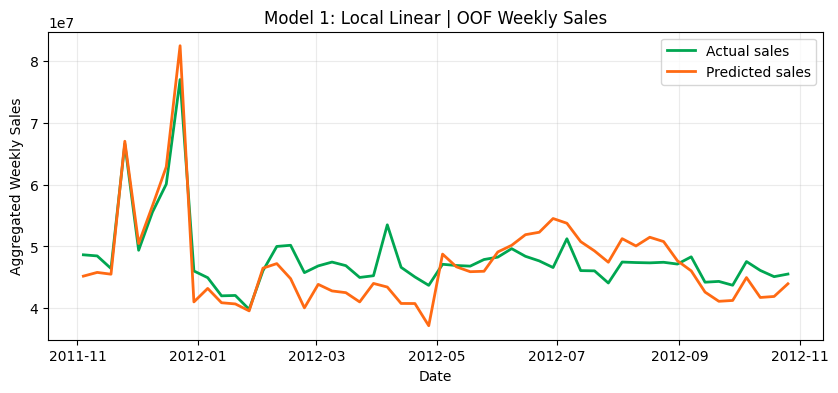

In [270]:
plot_weekly_actual_vs_pred(p1_oof, "Model 1: Local Linear | OOF Weekly Sales")

### Resultados LLR Lite

In [271]:
p1_lite_cfg

{'train_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet',
 'test_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet',
 'output_dir': 'outputs/phase1_local_linear_lite',
 'kernel': 'tricube',
 'bandwidth': 6,
 'min_samples': 16,
 'ridge': 0.0001,
 'coef_clip': 6.0,
 'anom_clip_scale': 2.0,
 'n_folds': 4,
 'val_weeks': 13,
 'max_series': None,
 'use_interactions': False,
 'feature_mode': 'lite',
 'lags': [1, 2],
 'interaction_cols': [],
 'exogenous_features': ['temp_anom', 'fuel_anom'],
 'feature_cols': ['temp_anom',
  'fuel_anom',
  'sales_anom_lag1',
  'sales_anom_lag2',
  'is_holiday_int'],
 'standard_scaler': True}

In [272]:
p1_lite_fold[["fold", "train_start", "train_end", "val_start", "val_end", "wmae", "mae", "rmse"]]

,fold,train_start,train_end,val_start,val_end,wmae,mae,rmse
0,1,2010-02-05,2011-10-28,2011-11-04,2012-01-27,2468.567458,2271.802436,4955.291247
1,2,2010-02-05,2012-01-27,2012-02-03,2012-04-27,2199.682469,2196.184633,4485.720535
2,3,2010-02-05,2012-04-27,2012-05-04,2012-07-27,2028.753667,2028.753667,3948.262807
3,4,2010-02-05,2012-07-27,2012-08-03,2012-10-26,1947.742271,1923.235682,3954.874629


In [273]:
p1_lite_mean[["wmae", "mae", "rmse"]]

wmae    2161.186467
mae     2104.994105
rmse    4336.037305
Name: 4, dtype: object

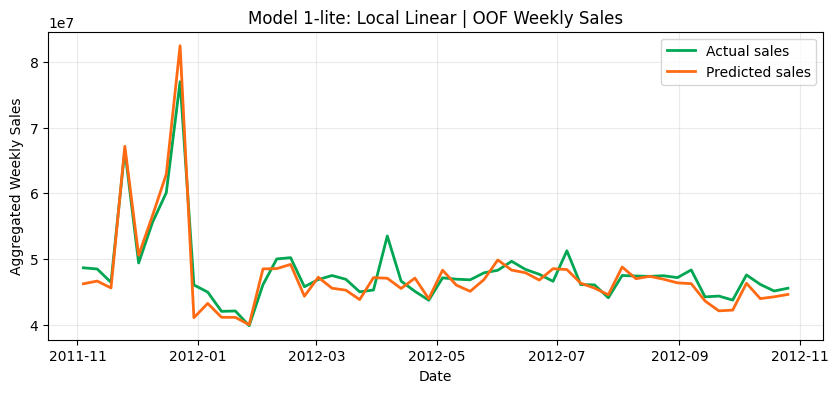

In [162]:
plot_weekly_actual_vs_pred(p1_lite_oof, "Model 1-lite: Local Linear | OOF Weekly Sales")

### Resultados Proceso Gausiano (AR)

In [274]:
make_param_df(
    [
        ("max_eval", p2_cfg["max_eval"], "Maximum evaluations in MAP optimization; higher allows deeper convergence."),
        ("pred_draws", p2_cfg["pred_draws"], "Number of stochastic recursive draws for predictive mean/uncertainty."),
        ("fourier_order", p2_cfg["fourier_order"], "Number of sine/cosine seasonal harmonics."),
        ("lag_orders", p2_cfg["lag_orders"], "Autoregressive lags used as structural predictors."),
        ("sigma_clusters", p2_cfg["sigma_clusters"], "Number of heteroskedastic noise clusters; 0 means shared sigma."),
        ("exogenous_features", p2_cfg.get("exogenous_features", []), "External covariates entering the structural mean."),
    ]
)

,Parameter,Value,How it works
0,max_eval,1800,Maximum evaluations in MAP optimization; highe...
1,pred_draws,40,Number of stochastic recursive draws for predi...
2,fourier_order,3,Number of sine/cosine seasonal harmonics.
3,lag_orders,"[1, 2]",Autoregressive lags used as structural predict...
4,sigma_clusters,0,Number of heteroskedastic noise clusters; 0 me...
5,exogenous_features,"[temp_anom, fuel_anom, MarkDown1, MarkDown2, M...",External covariates entering the structural mean.


In [275]:
p2_cfg

{'train_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet',
 'test_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet',
 'output_dir': 'outputs/phase2_structural_ar_full',
 'n_folds': 2,
 'val_weeks': 8,
 'max_eval': 1800,
 'random_seed': 8927,
 'pred_draws': 40,
 'fourier_order': 3,
 'sigma_clusters': 0,
 'max_series': None,
 'lag_orders': [1, 2],
 'exogenous_features': ['temp_anom',
  'fuel_anom',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment'],
 'note': 'Structural AR model with hierarchical series intercept, trend, Fourier seasonality, and recursive validation.'}

In [276]:
p2_fold[["fold", "train_start", "train_end", "val_start", "val_end", "wmae", "mae", "rmse", "runtime_sec"]]

,fold,train_start,train_end,val_start,val_end,wmae,mae,rmse,runtime_sec
0,1,2010-02-05,2012-07-06,2012-07-13,2012-08-31,1858.615285,1858.615285,3605.180332,41.105816
1,2,2010-02-05,2012-08-31,2012-09-07,2012-10-26,1788.747710,1814.821572,3515.619512,27.821251


In [277]:
p2_mean[["wmae", "mae", "rmse", "runtime_sec"]]

wmae           1823.681497
mae            1836.718428
rmse           3560.399922
runtime_sec      34.463533
Name: 2, dtype: object

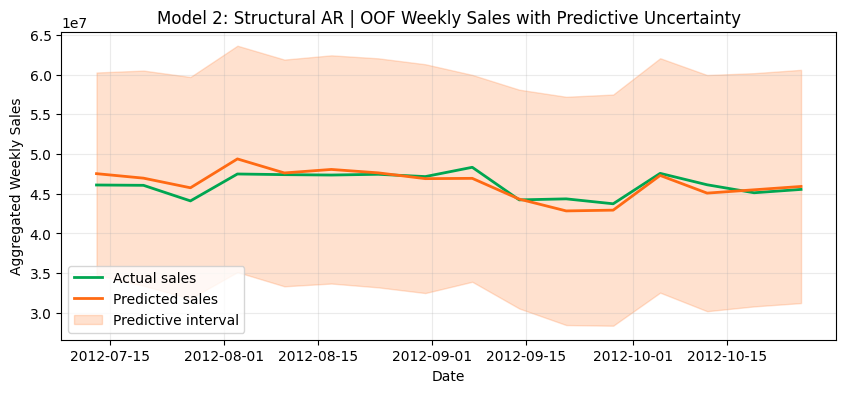

In [278]:
plot_weekly_actual_vs_pred(
    p2_oof,
    "Model 2: Structural AR | OOF Weekly Sales with Predictive Uncertainty",
    show_uncertainty=True,
)

### Resultado Elastic Net

In [168]:
make_param_df(
    [
        ("alpha", en_cfg["alpha"], "Overall regularization strength; larger values shrink coefficients more."),
        ("l1_ratio", en_cfg["l1_ratio"], "Mix between L1 (sparsity) and L2 (stability)."),
        ("max_iter", en_cfg["max_iter"], "Maximum coordinate-descent iterations for convergence."),
        ("lags", en_cfg["lags"], "Lag features used in recursive setup."),
        ("features", en_cfg["features"], "Full tabular interface for model fitting."),
    ]
)

,Parameter,Value,How it works
0,alpha,0.05,Overall regularization strength; larger values...
1,l1_ratio,0.3,Mix between L1 (sparsity) and L2 (stability).
2,max_iter,10000,Maximum coordinate-descent iterations for conv...
3,lags,"[1, 2]",Lag features used in recursive setup.
4,features,"[lag1, lag2, week_of_year, month, is_holiday_i...",Full tabular interface for model fitting.


In [169]:
en_cfg

{'train_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet',
 'test_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet',
 'output_dir': 'outputs/baselines/elastic_net',
 'n_folds': 4,
 'val_weeks': 13,
 'max_series': None,
 'alpha': 0.05,
 'l1_ratio': 0.3,
 'max_iter': 10000,
 'model': 'elastic_net',
 'target': 'sales_anom',
 'features': ['lag1',
  'lag2',
  'week_of_year',
  'month',
  'is_holiday_int',
  'temp_anom',
  'fuel_anom',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment'],
 'lags': [1, 2]}

In [170]:
en_fold[["fold", "train_start", "train_end", "val_start", "val_end", "wmae", "mae", "rmse", "runtime_sec"]]

,fold,train_start,train_end,val_start,val_end,wmae,mae,rmse,runtime_sec
0,1,2010-02-05,2011-10-28,2011-11-04,2012-01-27,2475.985274,2293.252765,4919.238999,0.866906
1,2,2010-02-05,2012-01-27,2012-02-03,2012-04-27,2207.708436,2224.478816,4446.840568,0.992713
2,3,2010-02-05,2012-04-27,2012-05-04,2012-07-27,1921.357797,1921.357797,3758.701811,0.948691
3,4,2010-02-05,2012-07-27,2012-08-03,2012-10-26,1805.900000,1774.649987,3661.513910,1.033331


In [172]:
en_mean[["wmae", "mae", "rmse", "runtime_sec"]]

wmae           2102.737877
mae            2053.434841
rmse           4196.573822
runtime_sec        0.96041
Name: 4, dtype: object

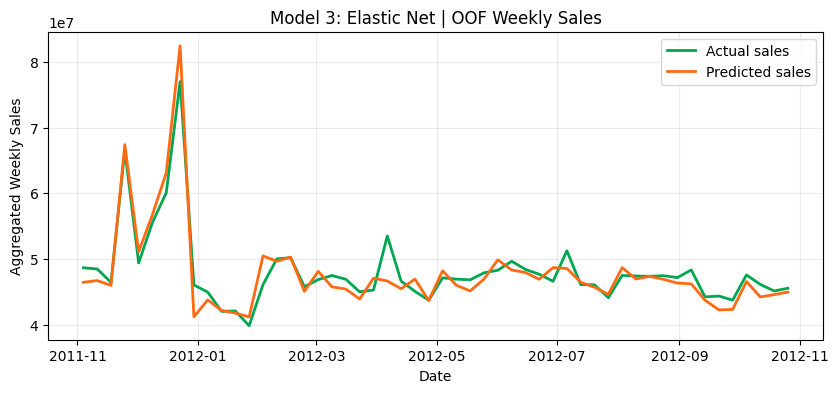

In [171]:
plot_weekly_actual_vs_pred(en_oof, "Model 3: Elastic Net | OOF Weekly Sales")

### Resultado Random Forest

In [173]:
make_param_df(
    [
        ("n_estimators", rf_cfg["n_estimators"], "Number of trees; larger reduces variance but increases runtime."),
        ("max_depth", rf_cfg["max_depth"], "Maximum tree depth; controls model complexity."),
        ("min_samples_leaf", rf_cfg["min_samples_leaf"], "Minimum samples per leaf; regularizes tree partitions."),
        ("max_features", rf_cfg["max_features"], "Feature subset size considered at each split."),
        ("lags", rf_cfg["lags"], "Autoregressive lag features used recursively."),
    ]
)

,Parameter,Value,How it works
0,n_estimators,160,Number of trees; larger reduces variance but i...
1,max_depth,22,Maximum tree depth; controls model complexity.
2,min_samples_leaf,1,Minimum samples per leaf; regularizes tree par...
3,max_features,sqrt,Feature subset size considered at each split.
4,lags,"[1, 2]",Autoregressive lag features used recursively.


In [174]:
rf_cfg

{'train_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet',
 'test_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet',
 'output_dir': 'outputs/baselines/random_forest',
 'n_folds': 4,
 'val_weeks': 13,
 'max_series': None,
 'n_estimators': 160,
 'max_depth': 22,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'model': 'random_forest',
 'target': 'sales_anom',
 'features': ['lag1',
  'lag2',
  'week_of_year',
  'month',
  'is_holiday_int',
  'temp_anom',
  'fuel_anom',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment'],
 'lags': [1, 2]}

In [175]:
rf_fold[["fold", "train_start", "train_end", "val_start", "val_end", "wmae", "mae", "rmse", "runtime_sec"]]

,fold,train_start,train_end,val_start,val_end,wmae,mae,rmse,runtime_sec
0,1,2010-02-05,2011-10-28,2011-11-04,2012-01-27,2448.471873,2248.049927,4908.325535,3.726079
1,2,2010-02-05,2012-01-27,2012-02-03,2012-04-27,2144.002646,2157.122843,4413.152265,4.437882
2,3,2010-02-05,2012-04-27,2012-05-04,2012-07-27,1915.995788,1915.995788,3650.625149,4.724520
3,4,2010-02-05,2012-07-27,2012-08-03,2012-10-26,1679.902840,1664.795344,3444.058588,5.243644


In [176]:
rf_mean[["wmae", "mae", "rmse", "runtime_sec"]]

wmae           2047.093287
mae            1996.490976
rmse           4104.040384
runtime_sec       4.533031
Name: 4, dtype: object

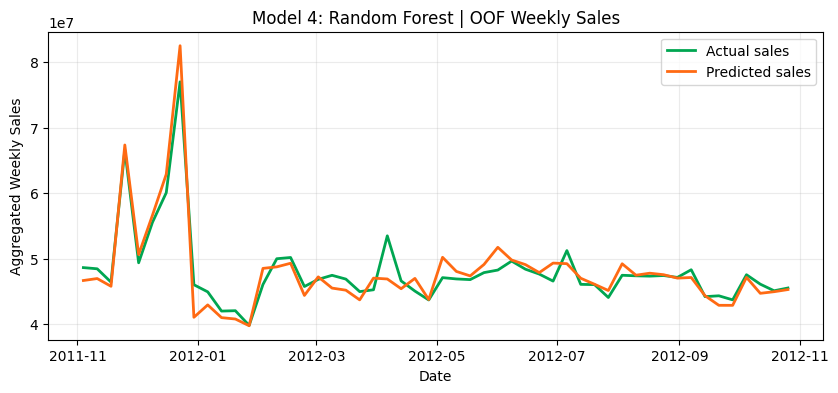

In [177]:
plot_weekly_actual_vs_pred(rf_oof, "Model 4: Random Forest | OOF Weekly Sales")

### Resultado ETS

In [178]:
make_param_df(
    [
        ("seasonal_periods", ets_cfg["seasonal_periods"], "Season length used by ETS seasonal state."),
        ("exog_alpha", ets_cfg.get("exog_alpha", None), "Ridge penalty for exogenous linear component."),
        ("exogenous_features", ets_cfg.get("exogenous_features", []), "Regressors used before ETS residual modeling."),
        ("n_folds", ets_cfg["n_folds"], "Forward-chaining fold count."),
        ("val_weeks", ets_cfg["val_weeks"], "Validation horizon length per fold."),
    ]
)

,Parameter,Value,How it works
0,seasonal_periods,52,Season length used by ETS seasonal state.
1,exog_alpha,1.0,Ridge penalty for exogenous linear component.
2,exogenous_features,"[temp_anom, fuel_anom, MarkDown1, MarkDown2, M...",Regressors used before ETS residual modeling.
3,n_folds,4,Forward-chaining fold count.
4,val_weeks,13,Validation horizon length per fold.


In [179]:
ets_cfg

{'train_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet',
 'test_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet',
 'output_dir': 'outputs/baselines/ets',
 'n_folds': 4,
 'val_weeks': 13,
 'max_series': None,
 'seasonal_periods': 52,
 'exog_alpha': 1.0,
 'model': 'ets',
 'target': 'sales_anom (via exogenous + ETS residual)',
 'exogenous_features': ['temp_anom',
  'fuel_anom',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment'],
 'cv_mode_counts': {'level': 10550,
  'level-trend': 1847,
  'global-fallback': 77,
  'last-value-fallback': 51,
  'level-seasonal': 2},
 'test_mode_counts': {'level': 2719,
  'level-trend': 411,
  'level-seasonal': 8,
  'global-fallback': 11,
  'last-value-fallback': 20}}

In [180]:
ets_fold[["fold", "train_start", "train_end", "val_start", "val_end", "wmae", "mae", "rmse", "runtime_sec"]]

,fold,train_start,train_end,val_start,val_end,wmae,mae,rmse,runtime_sec
0,1,2010-02-05,2011-10-28,2011-11-04,2012-01-27,2350.210994,2193.430784,4866.046429,35.455143
1,2,2010-02-05,2012-01-27,2012-02-03,2012-04-27,2036.512652,2050.230681,4093.131724,323.797742
2,3,2010-02-05,2012-04-27,2012-05-04,2012-07-27,1540.042559,1540.042559,3030.647527,334.129346
3,4,2010-02-05,2012-07-27,2012-08-03,2012-10-26,1442.141483,1444.279579,2974.737166,515.819794


In [181]:
ets_mean[["wmae", "mae", "rmse", "runtime_sec"]]

wmae           1842.226922
mae            1806.995901
rmse           3741.140712
runtime_sec     302.300506
Name: 4, dtype: object

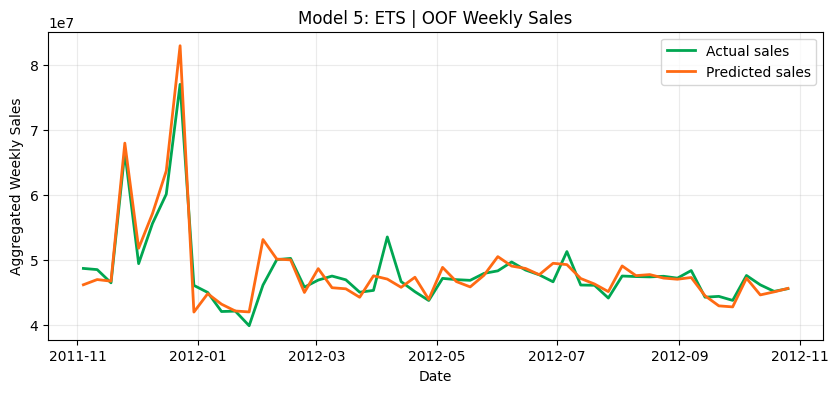

In [182]:
plot_weekly_actual_vs_pred(ets_oof, "Model 5: ETS | OOF Weekly Sales")

### Resultado AdaBoost

In [183]:
make_param_df(
    [
        ("n_estimators", ad_cfg["n_estimators"], "Number of boosting stages."),
        ("learning_rate", ad_cfg["learning_rate"], "Shrinkage per stage; smaller needs more estimators."),
        ("max_depth", ad_cfg["max_depth"], "Depth of each base regression tree."),
        ("loss", ad_cfg["loss"], "Boosting loss that controls how hard examples are re-weighted."),
        ("lags", ad_cfg["lags"], "Autoregressive lag inputs for recursive forecasting."),
    ]
)

,Parameter,Value,How it works
0,n_estimators,400,Number of boosting stages.
1,learning_rate,0.02,Shrinkage per stage; smaller needs more estima...
2,max_depth,3,Depth of each base regression tree.
3,loss,square,Boosting loss that controls how hard examples ...
4,lags,"[1, 2]",Autoregressive lag inputs for recursive foreca...


In [184]:
ad_cfg

{'train_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/train_feat.parquet',
 'test_path': '/home/ppalacios/Documents/Regression_Challenge_3-Walmart/walmart-recruiting-store-sales-forecasting/data/3.processed/test_feat.parquet',
 'output_dir': 'outputs/baselines/adaboost',
 'n_folds': 4,
 'val_weeks': 13,
 'max_series': None,
 'n_estimators': 400,
 'learning_rate': 0.02,
 'max_depth': 3,
 'loss': 'square',
 'model': 'adaboost',
 'target': 'sales_anom',
 'features': ['lag1',
  'lag2',
  'week_of_year',
  'month',
  'is_holiday_int',
  'temp_anom',
  'fuel_anom',
  'MarkDown1',
  'MarkDown2',
  'MarkDown3',
  'MarkDown4',
  'MarkDown5',
  'CPI',
  'Unemployment'],
 'lags': [1, 2]}

In [185]:
ad_fold[["fold", "train_start", "train_end", "val_start", "val_end", "wmae", "mae", "rmse", "runtime_sec"]]

,fold,train_start,train_end,val_start,val_end,wmae,mae,rmse,runtime_sec
0,1,2010-02-05,2011-10-28,2011-11-04,2012-01-27,2484.325260,2278.419476,4927.184916,122.836803
1,2,2010-02-05,2012-01-27,2012-02-03,2012-04-27,2194.568601,2196.823531,4386.792010,164.614742
2,3,2010-02-05,2012-04-27,2012-05-04,2012-07-27,2001.002929,2001.002929,3888.068247,188.977189
3,4,2010-02-05,2012-07-27,2012-08-03,2012-10-26,1814.980098,1795.546030,3696.075311,220.460867


In [186]:
ad_mean[["wmae", "mae", "rmse", "runtime_sec"]]

wmae           2123.719222
mae            2067.947992
rmse           4224.530121
runtime_sec       174.2224
Name: 4, dtype: object

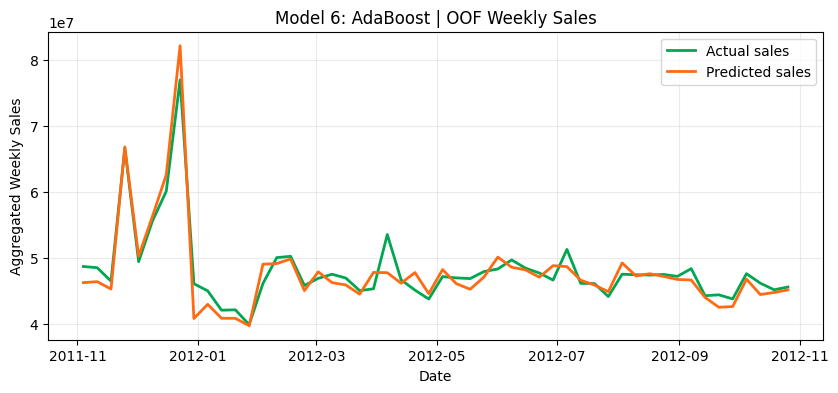

In [187]:
plot_weekly_actual_vs_pred(ad_oof, "Model 6: AdaBoost | OOF Weekly Sales")

### Comparación entre Modelos

En esta sección se consolidan los resultados de todos los modelos:

- Mean WMAE
- Mean MAE
- RMSE

El mejor modelo será aquel que logre el menor WMAE.

In [229]:
full_comparison = pd.DataFrame(
    [
        {
            "Model": "Local Linear Anomaly (Phase 1)",
            "Mean WMAE": float(p1_mean["wmae"]),
            "Mean MAE": float(p1_mean["mae"]),
            "Mean RMSE": float(p1_mean["rmse"]),
        },
        {
            "Model": "Structural AR (Phase 2)",
            "Mean WMAE": float(p2_mean["wmae"]),
            "Mean MAE": float(p2_mean["mae"]),
            "Mean RMSE": float(p2_mean["rmse"]),
        },
        {
            "Model": "Local Linear Lite (Phase 1-lite)",
            "Mean WMAE": float(p1_lite_mean["wmae"]),
            "Mean MAE": float(p1_lite_mean["mae"]),
            "Mean RMSE": float(p1_lite_mean["rmse"]),
        },
        {
            "Model": "Elastic Net (Phase 3)",
            "Mean WMAE": float(en_mean["wmae"]),
            "Mean MAE": float(en_mean["mae"]),
            "Mean RMSE": float(en_mean["rmse"]),
        },
        {
            "Model": "Random Forest (Phase 4)",
            "Mean WMAE": float(rf_mean["wmae"]),
            "Mean MAE": float(rf_mean["mae"]),
            "Mean RMSE": float(rf_mean["rmse"]),
        },
        {
            "Model": "ETS (Phase 5)",
            "Mean WMAE": float(ets_mean["wmae"]),
            "Mean MAE": float(ets_mean["mae"]),
            "Mean RMSE": float(ets_mean["rmse"]),
        },
        {
            "Model": "AdaBoost (Phase 7)",
            "Mean WMAE": float(ad_mean["wmae"]),
            "Mean MAE": float(ad_mean["mae"]),
            "Mean RMSE": float(ad_mean["rmse"]),
        },
    ]
).sort_values("Mean WMAE", ascending=True).reset_index(drop=True)
full_comparison

,Model,Mean WMAE,Mean MAE,Mean RMSE
0,ETS (Phase 5),1842.226922,1806.995901,3741.140712
1,Random Forest (Phase 4),2047.093287,1996.490976,4104.040384
2,Elastic Net (Phase 3),2102.737877,2053.434841,4196.573822
3,AdaBoost (Phase 7),2123.719222,2067.947992,4224.530121
4,Local Linear Lite (Phase 1-lite),2161.186467,2104.994105,4336.037305
5,Structural AR (Phase 2),2304.704061,2313.232295,4699.136486
6,Local Linear Anomaly (Phase 1),7334.921314,7378.861274,14566.596221


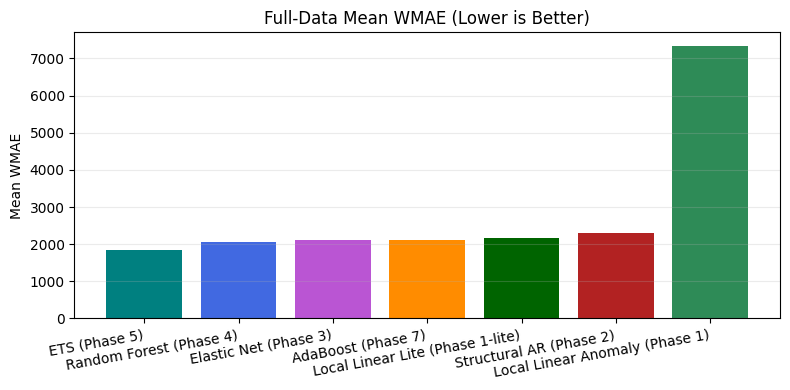

In [230]:
fig, ax = plt.subplots(figsize=(8, 4))
color_map = {
    "Local Linear Anomaly (Phase 1)": "seagreen",
    "Local Linear Lite (Phase 1-lite)": "darkgreen",
    "Structural AR (Phase 2)": "firebrick",
    "Elastic Net (Phase 3)": "mediumorchid",
    "Random Forest (Phase 4)": "royalblue",
    "ETS (Phase 5)": "teal",
    "AdaBoost (Phase 7)": "darkorange",
}
bar_colors = [color_map[m] for m in full_comparison["Model"]]
ax.bar(
    full_comparison["Model"],
    full_comparison["Mean WMAE"],
    color=bar_colors,
)
ax.set_title("Full-Data Mean WMAE (Lower is Better)")
ax.set_ylabel("Mean WMAE")
ax.grid(axis="y", alpha=0.25)
plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.show()

## 9. Conclusiones y trabajo futuro

Se resumen los hallazgos principales y se plantean posibles mejoras futuras.

A partir del análisis desarrollado se concluye que:

- La predicción de ventas semanales en un entorno retail está fuertemente determinada por componentes temporales estructurales.

- Los modelos lineales son insuficientes para capturar la complejidad observada.

- Los modelos basados en árboles mejoran el desempeño, evidenciando interacciones no lineales.

- El modelo ETS obtiene el mejor desempeño general debido a su capacidad para modelar explícitamente el error, tendencia y estacionalidad.

La selección del modelo no debe basarse únicamente en su sofisticación algorítmica, sino en su alineación con la estructura real del problema.

**Se proponen los siguientes pasos:**

- Explorar enfoques como Gradient Boosting o modelos basados en LightGBM.

- Incorporar validaciones temporales más extensas para evaluar estabilidad en horizontes mayores.

- Analizar efectos diferenciados por categoría para construir modelos segmentados.

    - En esto el modelamiento con procesos gausianos podria ser mejor, ya que podemos asumir una estructura variable por departamento y tienda.